## Load and Create Dataset

In [ ]:
pip install google-cloud-bigquery

In [1]:
from google.cloud import bigquery
from google.oauth2 import service_account
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# Setup Google Cloud BigQuery API

# Replace with your own key path
key_path = "/Users/theodoreleeiv/Documents/Documents - Theodore’s MacBook Pro/Google Cloud/inbound-density-428819-p8-aef577a5f38e.json"
credentials = service_account.Credentials.from_service_account_file(key_path)

client = bigquery.Client()


def QUERY(query):
    """
    Queries BigQuery
    :param query: string
    :return: dataframe
    """
    query = str(query)
    query_job = client.query(query)
    return query_job.result().to_dataframe()

In [834]:

df = QUERY("""
  SELECT
    r.subject_id,
    r.stay_id,
    r.hadm_id,
    r.readmit_stay_id,
    edadmitdate,
    eddischargedate,
    EXTRACT(DAYOFWEEK FROM eddischargedate) AS discharge_dow,
    EXTRACT(MONTH FROM eddischargedate) AS discharge_month,
    edadmithour,
    eddischargehour,
    LOS_hr,
    arrival_transport,
    disposition,
    gender,
    anchor_age,
    insurance,
    marital_status,
    language,
    race_group,
    temperature,
    heartrate,
    resprate,
    o2sat,
    sbp,
    dbp,
    acuity,
    m.name AS med_name,
    icd_title,
    mental_health_category,
    had_readmission_within_30
  

FROM
  `inbound-density-428819-p8.patient_info.MH-ED-READMISSIONS` AS r

LEFT JOIN
  `inbound-density-428819-p8.patient_info.MH-PATIENT-DEMO` AS p

ON r.subject_id = p.subject_id

LEFT JOIN
  `inbound-density-428819-p8.patient_info.MH-ED-DIAGNOSIS` AS d
ON
  r.stay_id = d.stay_id
  
LEFT JOIN
    `physionet-data.mimiciv_ed.triage` AS t
ON 
    r.stay_id = t.stay_id
LEFT JOIN 
    `physionet-data.mimiciv_ed.medrecon` AS m
ON  
    r.stay_id = m.stay_id
  
WHERE d.is_mh_disorder = 1
""")

In [4]:
# Calculate the number of comorbities per patient per visit

comorbities = QUERY("""
  SELECT
    subject_id,
    stay_id,
    SUM(num_comorbities) AS num_comorbitites
    FROM
    (SELECT
      d.subject_id,
      d.stay_id,
      CASE
        WHEN seq_num > 1 THEN 1
        ELSE 0
      END AS num_comorbities
    FROM
      `inbound-density-428819-p8.patient_info.MH-ED-DIAGNOSIS` AS d

    WHERE d.is_mh_disorder = 1
    ORDER BY
      num_comorbities DESC) AS patient_counts
GROUP BY
  subject_id,stay_id

""")

In [835]:
# merge the number of comorbitites with the main dataframe on subject_id and stay_id
df = df.merge(comorbities,how='left',on=['subject_id','stay_id'])

### Drop Duplicates

In [836]:
# Drop any duplicates if there are any in the data
df.drop_duplicates(inplace=True)

### Split the Data into training and test sets

In [838]:
from sklearn.model_selection import train_test_split
train_df,test_df = train_test_split(df,test_size=0.25,random_state=42,stratify=df['had_readmission_within_30'])

In [839]:
train_df.head()

,subject_id,stay_id,hadm_id,readmit_stay_id,edadmitdate,eddischargedate,discharge_dow,discharge_month,edadmithour,eddischargehour,...,resprate,o2sat,sbp,dbp,acuity,med_name,icd_title,mental_health_category,had_readmission_within_30,num_comorbitites
208946,11582633,39169883,<NA>,39169883,2142-11-12,2142-11-12,2,11,15,21,...,18.000000000,100.000000000,130.000000000,50.000000000,2.000000000,clonidine HCl,"Major depressive disorder, single episode, uns...",Mood Disorders,1,0
282526,19903052,32896221,<NA>,<NA>,2154-12-03,2154-12-03,3,12,17,21,...,16.000000000,97.000000000,153.000000000,88.000000000,2.000000000,None,ANXIETY STATE NOS,Anxiety and Related Disorders,0,2
399210,18542207,38480567,<NA>,38480567,2157-08-23,2157-08-24,4,8,22,9,...,16.000000000,97.000000000,121.000000000,97.000000000,3.000000000,albuterol sulfate,"Alcohol dependence with intoxication, unspecified",Substance-Related Mental Disorders,0,0
21092,15800543,37026479,21912474,<NA>,2165-10-02,2165-10-03,5,10,17,1,...,18.000000000,100.000000000,135.000000000,87.000000000,2.000000000,None,DEPRESSIVE DISORDER,Mood Disorders,0,0
411332,13294123,39300327,24848392,<NA>,2139-01-01,2139-01-01,5,1,10,21,...,16.000000000,100.000000000,213.000000000,194.000000000,1.000000000,Lisinopril,PARANOIA,Psychotic Disorders,0,2


In [840]:
train_df.shape

(205143, 31)

### Check for NaNs

In [841]:
train_df.isnull().sum()

subject_id                        0
stay_id                           0
hadm_id                       63900
readmit_stay_id              142091
edadmitdate                       0
eddischargedate                   0
discharge_dow                     0
discharge_month                   0
edadmithour                       0
eddischargehour                   0
LOS_hr                            0
arrival_transport                 0
disposition                       0
gender                            0
anchor_age                       13
insurance                     21499
marital_status                12718
language                      10271
race_group                        0
temperature                    7697
heartrate                      4887
resprate                       6989
o2sat                          6381
sbp                            5268
dbp                            5860
acuity                         1090
med_name                      23237
icd_title                   

There is quite of bit of NaNs in the data. However, some NaNs are expected in hadm_id, not all patients have an associated hadm_id or readmit_stay_id, days_to_readmission, med_name (medication name).

### Clean and Transform Columns

In [842]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 205143 entries, 208946 to 64885
Data columns (total 31 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   subject_id                 205143 non-null  Int64 
 1   stay_id                    205143 non-null  Int64 
 2   hadm_id                    141243 non-null  Int64 
 3   readmit_stay_id            63052 non-null   Int64 
 4   edadmitdate                205143 non-null  dbdate
 5   eddischargedate            205143 non-null  dbdate
 6   discharge_dow              205143 non-null  Int64 
 7   discharge_month            205143 non-null  Int64 
 8   edadmithour                205143 non-null  Int64 
 9   eddischargehour            205143 non-null  Int64 
 10  LOS_hr                     205143 non-null  Int64 
 11  arrival_transport          205143 non-null  object
 12  disposition                205143 non-null  object
 13  gender                     205143 non-null  o

In [843]:
# set the index to stay_id
train_df.set_index('stay_id',inplace=True)


Cleaning/Transformation Tasks
- Convert gender column to numeric binary
- Change the dtype of temperature, heartrate, reprate,o2sat, sbp, dbp, pain, and acuity to float values
- Unmarried individuals, feature engineer a binary variable, married vs unmarried
- Black/African Patiants, feature engineer a binary variable, Black/African?
- PORTUGUESE Patiants, feature engineer a binary variable, PORTUGUESE?
- Cuban Patiants, feature engineer a binary variable, Cuban?
- BLACK/AFRICAN AMERICAN patiants, feature engineer a binary variable, BLACK/AFRICAN AMERICAN?
- Puerto Rican Patiants, feature engineer a binary variable, Puerto Rican?
- Unknown Patiants, feature engineer a binary variable, Unknown?
- Hispanic or Latino Patiants, feature engineer a binary variable, Hispanic or Latino?
- Honduran Patiants, feature engineer a binary variable, Honduran?
- Patients 50 - 59
- Patients 40 - 49
- Num of Comorbitites
- Various medications (Create medication frequiences accounting for medications not listed by setting the default to 0) -> compute frequencies on the training set to prevent data leakage

In [15]:
# Create a customtransofrmer for each column transformation for the pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# Change gender column to a binary

class GenderMapper(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.gender_map = {'F': 0, 'M': 1}  

    def fit(self, X, y=None):
        return self  

    def transform(self, X):
        X_copy = X.copy()
        # Apply the gender mapping to the gender column
        if 'gender' in X_copy.columns:
            X_copy['gender'] = X_copy['gender'].map(self.gender_map)
        return X_copy

In [16]:
# change the dtype of temperature, heartrate, reprate,o2sat, sbp, dbp, and acuity to float values
class ConvertVitalSignsToFloats(BaseEstimator, TransformerMixin):
    """
    Converts Vital Signs to Floats
    """
    def __init__(self):
        self.type = float
    def fit(self, X, y=None):
        return self  
    def transform(self, X):
        X_copy = X.copy()
        
        vital_cols = ['temperature','heartrate','resprate','o2sat','sbp','dbp','acuity']
        
        for col in vital_cols:
            if col in X_copy.columns:
                try:
                    X_copy[col] =  X_copy[col].astype(float)
                except ValueError as e:
                    print(f"[Error] Could not convert column '{col}' to float. Error: {e} converting to NaN")
                    X_copy[col] = pd.to_numeric(X_copy[col], errors='coerce')
                    
            else:
                print(f'Not Column {col} not found in list')
        return X_copy
    
class CelsiusToFahrenheit(BaseEstimator, TransformerMixin):
    """
    Converts temperature signs recorded in celsisus to fahrenheit
    """
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self  
    def transform(self, X):
        X_copy = X.copy()
        
        if 'temperature' in X_copy.columns:
            try:
                 # Create a mask for likely Celsius values
                mask = X_copy['temperature'] <= 38
                X_copy.loc[mask, 'temperature'] = X_copy.loc[mask, 'temperature'] * 9/5 + 32
            except ValueError as e:
                print(f"[Error] Could not convert column. Error: {e}")
        return X_copy
    

In [17]:
# Create an unmarried vs married column from marital status column
class MaritalStatusMapper(BaseEstimator, TransformerMixin):
    """
    Converts marital status to a binary variable, married/partnered vs single/ not partnered
    """
    def __init__(self):
        self.is_married_map = {'None':1,'MARRIED':1,'WIDOWED':0,'DIVORCED':0,'SINGLE':0}

    def fit(self, X, y=None):
        return self  

    def transform(self, X):
        X_copy = X.copy()
        # Apply the gender mapping to the gender column
        if 'marital_status' in X_copy.columns:
            X_copy['marital_status'] = X_copy['marital_status'].map(self.is_married_map)
        return X_copy


In [18]:
class GetTotalAdmissionsAndDischarges(BaseEstimator, TransformerMixin):
    """
    Calculates total admissions and discharges per admission day and discharge day, respectively
    """
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self  

    def transform(self, X):
        X_copy = X.copy().reset_index()
        
        # calculate the total admissions and total discharges 
        total_admissions = X_copy.groupby(by='edadmitdate')['stay_id'].count().reset_index().rename(columns={'stay_id':'total_admissions'})
        total_discharges = X_copy.groupby(by='eddischargedate')['stay_id'].count().reset_index().rename(columns={'stay_id':'total_discharges'})
        
        # merge these with original dataframe
        X_copy = X_copy.merge(total_admissions,how='left',on=['edadmitdate'])
        X_copy = X_copy.merge(total_discharges,how='left',on=['eddischargedate'])
        X_copy.drop(['edadmitdate','eddischargedate'],axis=1,inplace=True)
        X_copy.set_index('stay_id', inplace=True)
        return X_copy


In [19]:
from collections import defaultdict

class GetMedicationFrequencies(BaseEstimator, TransformerMixin):
    """
    Encode medications using their frequency
    """
    def __init__(self):
        self.med_to_freq = None
        self.freq_to_meds = None

    def fit(self, X, y=None):
        # Learn med freqencies
        freqs =  X['med_name'].value_counts().to_dict()
        
        # Mapping: med_names → frequency
        self.med_to_freq = defaultdict(lambda: 0, freqs)
        
        # Mapping: frequency → set of med_names
        self.freq_to_meds = defaultdict(set)
        for med, freq in freqs.items():
            self.freq_to_meds[freq].add(med)

        return self  

    def transform(self, X):
        X_copy = X.copy()
        # Replace meds with their frequency
        X_copy['med_name'] =  X_copy['med_name'].map(self.med_to_freq)
        
        # Rename the med column name
        X_copy.rename(columns={'med_name':'med_freq_id'},inplace=True)
        
        # Create a dataframe of the sum of frequencies per visit

        med_freq_id = X_copy.groupby(['stay_id'])['med_freq_id'].sum().reset_index()
        med_freq_id.rename(columns={'med_freq_id':'sum_of_med_freq_id'},inplace=True)
        
        # Drop the old med freq id
        X_copy.drop(columns=['med_freq_id'],axis=1,inplace=True)
        
        # merge the sum of frequiences per visit back to original dataframes
        X_copy = X_copy.merge(med_freq_id,how='left',on=['stay_id'])
        X_copy.set_index('stay_id', inplace=True)
        
        return X_copy
    



In [20]:
class GetLanguageFrequencies(BaseEstimator, TransformerMixin):
    """
    Encode medications using their frequency
    """
    def __init__(self):
        self.language_to_freq = None
        self.freq_to_language = None

    def fit(self, X, y=None):
        # Learn med freqencies
        freqs =  X['language'].value_counts().to_dict()
        
        # Mapping: languages → frequency
        self.language_to_freq = defaultdict(lambda: 0, freqs)
        
        # Mapping: frequency → set of languages
        self.freq_to_language = defaultdict(set)
        for language, freq in freqs.items():
            self.freq_to_language[freq].add(language)

        return self  

    def transform(self, X):
        X_copy = X.copy()
        # Replace meds with their frequency
        X_copy['language'] =  X_copy['language'].map(self.language_to_freq)
        
        # Rename the med column name
        X_copy.rename(columns={'language':'language_freq_id'},inplace=True)
        
        # Create a dataframe of the sum of frequencies per visit

        language_freq_id = X_copy.groupby(['stay_id'])['language_freq_id'].sum().reset_index()
        language_freq_id.rename(columns={'language_freq_id':'sum_of_language_freq_id'},inplace=True)
        
        # Drop the old language freq id
        X_copy.drop(columns=['language_freq_id'],axis=1,inplace=True)
    
        
        # merge the sum of frequiences per visit back to original dataframes
        X_copy = X_copy.merge(language_freq_id,how='left',on=['stay_id'])
        X_copy.set_index('stay_id', inplace=True)
        
        return X_copy

In [21]:
class GetDisposition(BaseEstimator, TransformerMixin):
    """
    Creates a binary variable to indiciate whether a patient LWBS or was treated prior to leaving the facility
    """
    def __init__(self):
        self.dispositions = ['ELOPED','LEFT AGAINST MEDICAL ADVICE','LEFT WITHOUT BEING SEEN']

    def fit(self, X, y=None):
        return self  

    def transform(self, X):
        X_copy = X.copy()
        # 1 if the patient left without getting proper treatment else 0
        X_copy['disposition'] = X_copy['disposition'].apply(lambda x: 1 if x in self.dispositions else 0 )
        return X_copy

In [22]:
class GetDiagnosesFrequencies(BaseEstimator, TransformerMixin):
    """
    Encode Patient Diagnoses and creates a summed value
    """
    def __init__(self):
        self.diagnosis_to_freq = None
        self.freq_to_diangosis = None

    def fit(self, X, y=None):
        # Learn med freqencies
        freqs =  X['icd_title'].value_counts().to_dict()
        
        # Mapping: diagnosis_names → frequency
        self.diagnosis_to_freq = defaultdict(lambda: 0, freqs)
        
        # Mapping: frequency → set of diagnosis_names
        self.freq_to_diangosis = defaultdict(set)
        for diagnosis, freq in freqs.items():
            self.freq_to_diangosis[freq].add(diagnosis)

        return self  

    def transform(self, X):
        X_copy = X.copy()
        # Replace meds with their frequency
        X_copy['icd_title'] =  X_copy['icd_title'].map(self.diagnosis_to_freq)
        
        # Rename the icd title column name
        X_copy.rename(columns={'icd_title':'icd_freq_id'},inplace=True)
        
        # Create a dataframe of the sum of frequencies per visit
        icd_freq_id = X_copy.groupby(['stay_id'])['icd_freq_id'].sum().reset_index()
        icd_freq_id.rename(columns={'icd_freq_id':'sum_of_icd_freq_id'},inplace=True)
        
        # Drop the old diangoses freq id
        X_copy.drop(columns=['icd_freq_id'],inplace=True)
        
        
        # merge the sum of frequiences per visit back to original dataframes
        X_copy = X_copy.merge(icd_freq_id,how='left',on=['stay_id'])
        X_copy.set_index('stay_id', inplace=True)
        
        return X_copy

In [23]:
class InsuranceMapper(BaseEstimator, TransformerMixin):
    """
    Create a binary variable for low readmission based on insurance type
    """
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self  

    def transform(self, X):
        X_copy = X.copy()
        X_copy['low_readmit_insurance'] = X_copy['insurance'].apply(lambda x: 1 if x in ['Private', 'None'] else 0)
        
        return X_copy

In [24]:
class NumericImputer(BaseEstimator, TransformerMixin):
    """
    Only imputes numeric columns
    """
    def __init__(self, strategy='mean'):
        self.strategy = strategy
        self.imputer = SimpleImputer(strategy=self.strategy)
        self.numeric_cols = []

    def fit(self, X, y=None):
        self.numeric_cols = X.select_dtypes(include='number').columns
        self.imputer.fit(X[self.numeric_cols])
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy[self.numeric_cols] = self.imputer.transform(X_copy[self.numeric_cols])
        return X_copy

In [25]:
class StandardScalar_Custom(BaseEstimator, TransformerMixin):
    """
    Only scale numeric columns
    """
    def __init__(self):
        self.scaler = StandardScaler()
        self.numeric_cols = []

    def fit(self, X, y=None):
        self.numeric_cols = X.select_dtypes(include='number').columns
        self.scaler.fit(X[self.numeric_cols])
        return self

    def transform(self, X):
        X_copy = X.copy()
        
        X_copy[self.numeric_cols] = self.scaler.transform(X_copy[self.numeric_cols])
        return X_copy
    
    def inverse_transform(self, X):
        X_copy = X.copy()
        X_copy[self.numeric_cols] = self.scaler.inverse_transform(X_copy[self.numeric_cols])
        return X_copy

In [26]:
class CreateDummies(BaseEstimator, TransformerMixin):
    """
    Convert categorical 'object' columns into dummy variables.
    """
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        self.dummy_columns = X.select_dtypes(include=['object']).columns.tolist()  # Identify categorical columns
        return self  # Return self for pipeline compatibility

    def transform(self, X):
        X_copy = X.copy()  # Copy input DataFrame to avoid changing original
        # Create dummy variables for categorical columns, drop first category to avoid multicollinearity
        X_copy = pd.get_dummies(X_copy, columns=self.dummy_columns, dtype='Int64', drop_first=True)
        return X_copy  # Return transformed DataFrame

### Create Preprocessing Pipeline

In [845]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Build Preprocessing Pipeline for later preprocessing of new data
X_train_preprocessing_Pipeline = Pipeline(
    [
        ('ConvertVitalSigns',ConvertVitalSignsToFloats()), # Converts vital signs to floats
        ('CelsiusToFahrenheit',CelsiusToFahrenheit()), # Standardizes temperature, converting it to Fahrenheit
        ('GetMedicationFrequencies',GetMedicationFrequencies()),# Converts medications into frequencies
        ('GetDiagnosesFrequencies',GetDiagnosesFrequencies()), # Converts Diagnosis to frequencies
        ('GetLanguageFrequencies',GetLanguageFrequencies()), # Converts languages to frequencies
        ('GetTotalAdmissionsAndDischarges',GetTotalAdmissionsAndDischarges()), # Calcaultes the total number of admissions and discharges for a given day
        ('Scaler', StandardScalar_Custom()), # Scales data
        ('MapGender',GenderMapper()), # Maps gender to 1 or 0, 1: male, 0: female
        ('MaritalStatusMapper',MaritalStatusMapper()), # Maps maritalstats to 1 or 0, 1: ismarried, 0: not married
        ('GetDisposition',GetDisposition()), # Maps disposition to 1 or 0. 1: LWBS, 0: Got treatment
        ('MapInsurance',InsuranceMapper()),# Maps insurance to 1 or 0. 1: low readmission, 0: high readmission
        ('OnehotEncoder',CreateDummies()),
        ('SimpleImputer', NumericImputer(strategy='mean')),  # Fill the nulls with the mean value for applicable features
    ]
)

train_df_cleaned = X_train_preprocessing_Pipeline.fit_transform(train_df.drop(['had_readmission_within_30'],axis=1))



In [846]:
train_df_cleaned = train_df_cleaned.merge(train_df[['had_readmission_within_30']],left_index=True,right_index=True,how='left')
train_df_cleaned.drop_duplicates(inplace=True)

In [847]:
print('train shape:',train_df_cleaned.shape)

train shape: (51497, 52)


In [33]:
train_df_cleaned.columns

Index(['subject_id', 'hadm_id', 'readmit_stay_id', 'discharge_dow',
       'discharge_month', 'edadmithour', 'eddischargehour', 'LOS_hr', 'gender',
       'anchor_age', 'marital_status', 'temperature', 'heartrate', 'resprate',
       'o2sat', 'sbp', 'dbp', 'acuity', 'num_comorbitites',
       'sum_of_med_freq_id', 'sum_of_icd_freq_id', 'sum_of_language_freq_id',
       'total_admissions', 'total_discharges', 'low_readmit_insurance',
       'arrival_transport_HELICOPTER', 'arrival_transport_OTHER',
       'arrival_transport_UNKNOWN', 'arrival_transport_WALK IN',
       'disposition_ELOPED', 'disposition_EXPIRED', 'disposition_HOME',
       'disposition_LEFT AGAINST MEDICAL ADVICE',
       'disposition_LEFT WITHOUT BEING SEEN', 'disposition_OTHER',
       'disposition_TRANSFER', 'insurance_Medicare', 'insurance_No charge',
       'insurance_Other', 'insurance_Private', 'race_group_Asian',
       'race_group_Black / African American', 'race_group_Hispanic / Latino',
       'race_group_Mul

### Describe the Data

In [848]:
train_df_cleaned.describe()

,subject_id,hadm_id,readmit_stay_id,discharge_dow,discharge_month,edadmithour,eddischargehour,LOS_hr,disposition,gender,...,mental_health_category_Childhood and Adolescent Disorders,mental_health_category_Developmental Disorders,mental_health_category_Intellectual Disabilities,mental_health_category_Mood Disorders,mental_health_category_Organic Mental Health Disorders,mental_health_category_Personality and Behavioral Disorders,mental_health_category_Psychotic Disorders,mental_health_category_Substance-Related Mental Disorders,mental_health_category_Unspecified Mental Disorders,had_readmission_within_30
count,51497.000000,5.149700e+04,5.149700e+04,51497.000000,51497.000000,51497.000000,51497.000000,51497.000000,51497.000000,51497.000000,...,51497.000000,51497.000000,51497.000000,51497.000000,51497.000000,51497.000000,51497.000000,51497.000000,51497.000000,51497.0
mean,0.033736,5.320036e-03,-1.095839e-02,0.006438,-0.001851,-0.031609,-0.126587,-0.050114,0.060314,0.618211,...,0.005631,0.002136,0.004408,0.260093,0.055071,0.006699,0.078956,0.481659,0.000078,0.275026
std,1.014319,8.099987e-01,5.342689e-01,0.996915,0.998063,1.111029,0.992643,0.929758,0.238070,0.485830,...,0.074832,0.046168,0.066247,0.438689,0.228121,0.081576,0.269673,0.499668,0.008813,0.446532
min,-1.811389,-1.727896e+00,-1.774790e+00,-1.483472,-1.619527,-2.205287,-2.038255,-0.927484,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,-0.813647,-4.074082e-01,-4.337075e-16,-0.986993,-0.754516,-0.730741,-0.976928,-0.567175,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,0.079116,5.784230e-16,-4.337075e-16,0.005966,0.110495,0.088452,-0.067220,-0.350989,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
75%,0.884790,4.254470e-01,-4.337075e-16,0.998924,0.975506,0.907644,0.690871,0.153444,0.000000,1.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.0
max,1.842599,1.741687e+00,1.683025e+00,1.495403,1.552181,1.562998,1.448961,12.980461,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0


## Data Analysis

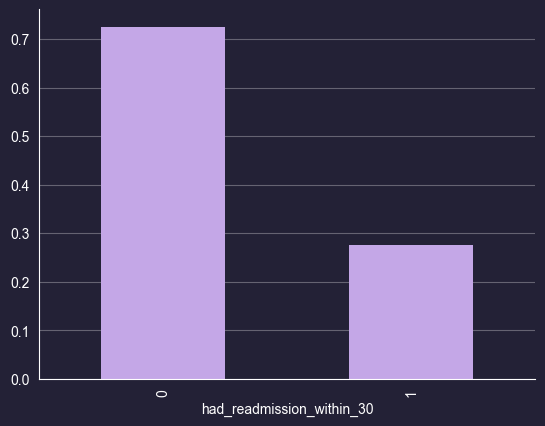

In [856]:
# Check for class imbalance
fig,ax = plt.subplots(1,1)
train_df_cleaned['had_readmission_within_30'].value_counts(normalize=True).plot(kind='bar',ax=ax,edgecolor='none',color='#C4A7E7')
# Remove the top and right spines (the borders around the plot area) for a cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Disable vertical grid lines (along x-axis)
ax.grid(axis='x', visible=False)

# Enable horizontal grid lines (along y-axis) with a light solid line and some transparency
ax.grid(axis='y', linestyle='-', alpha=0.3)

# Set the figure background color to a dark gray/black shade
fig.patch.set_facecolor('#232136')

# Set the axes (plot area) background to the same dark color
ax.set_facecolor('#232136')


#### Class Imblance
There is a significant class imbalance between patients who are readmitted within 30 days of an index visit and those who are not. This imbalance can severely impact the predictive performance of machine learning models, especially if not addressed properly.

For example, a model evaluated using a simple metric like accuracy may appear to perform well by predominantly predicting the majority class. However, it may fail to correctly identify patients at high risk of readmission — the minority class — which carries far greater clinical and financial consequences. Misclassifying a high-risk patient could result in an unplanned readmission, which on average costs the healthcare system approximately $5,000. In contrast, misclassifying a low-risk patient as high-risk may only result in unnecessary follow-up, consuming clinician time but with far less financial impact.

Therefore, it's essential to apply techniques such as resampling, cost-sensitive learning, or appropriate evaluation metrics (e.g., precision, recall, or cost-based analysis) to ensure the model remains effective and clinically useful.

To effectively evaluate my models for this task, I will use metrics such as precision, recall, F1-score, and the confusion matrix, which provide deeper insight into the model’s performance—particularly in the presence of class imbalance.

### Identify Multicolinearited Features

Some models may perform poorly when input features are highly correlated, as this multicollinearity can reduce predictive power and model stability. Addressing this by combining correlated variables or removing redundant ones can help reduce dimensionality and simplify the model, potentially improving both performance and interpretability.

In [36]:
# Variables that are linearly correlated with each other may be communicating the same information. So, I can just identify them in advance and remove them from the analysis or I can combine them into one variable all together.
from statsmodels.stats.outliers_influence import variance_inflation_factor
# VIF is a statistical method used to detect and quantify multicollinearity in regression models. It helps identify how much the variance of a regression coefficient is inflated due to the correlation between predictor variables.

features = train_df_cleaned.select_dtypes(include='float').drop(columns=['subject_id','hadm_id','readmit_stay_id'])
X = features.values

# VIF DataFrame
vif_df = pd.DataFrame()
# calculating VIF for each feature
vif_df['feature'] = features.columns
vif_df.set_index('feature', inplace=True)
vif_df["VIF"] = [round(variance_inflation_factor(X, i),1)
                          for i,value in enumerate(features)]



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


<Axes: ylabel='feature'>

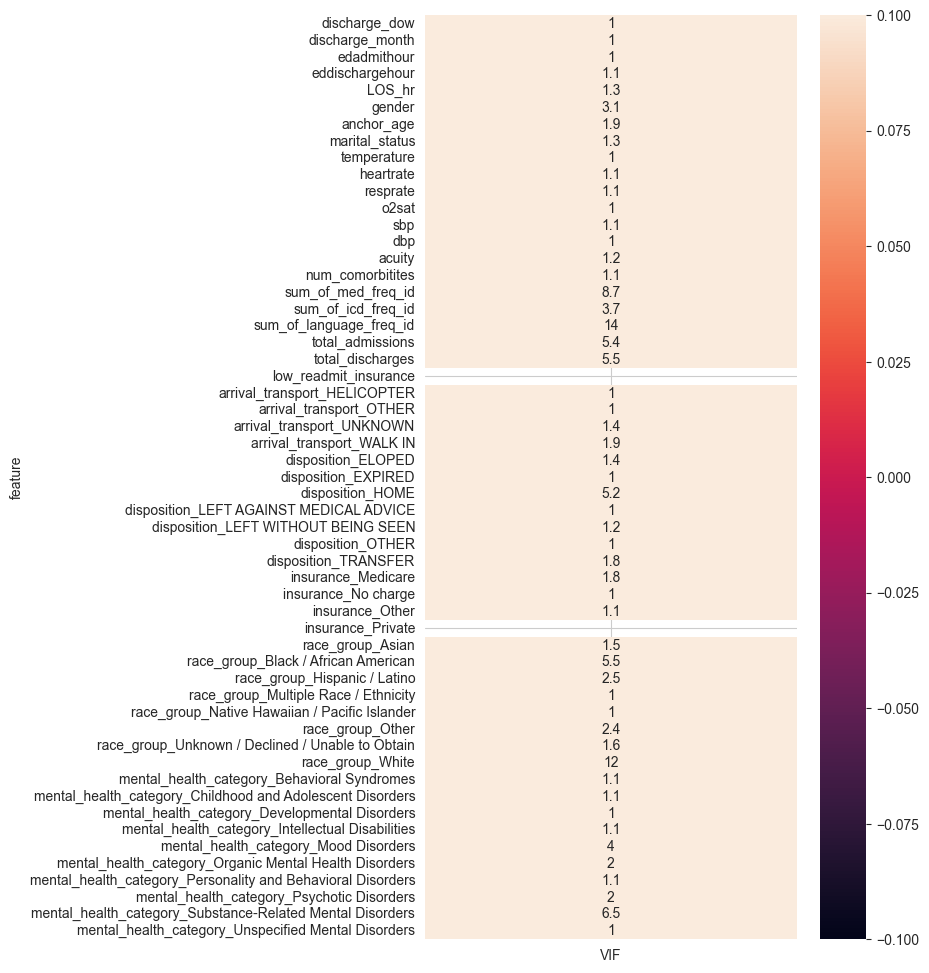

In [37]:
# Plot Heat Map
fig,ax = plt.subplots(figsize=(6,12))
sns.heatmap(vif_df,annot=True)

It seems that most variables have a low VIF indicating there isn't much multicolinearity. To get a better look I will use a correlation matrix

<Axes: >

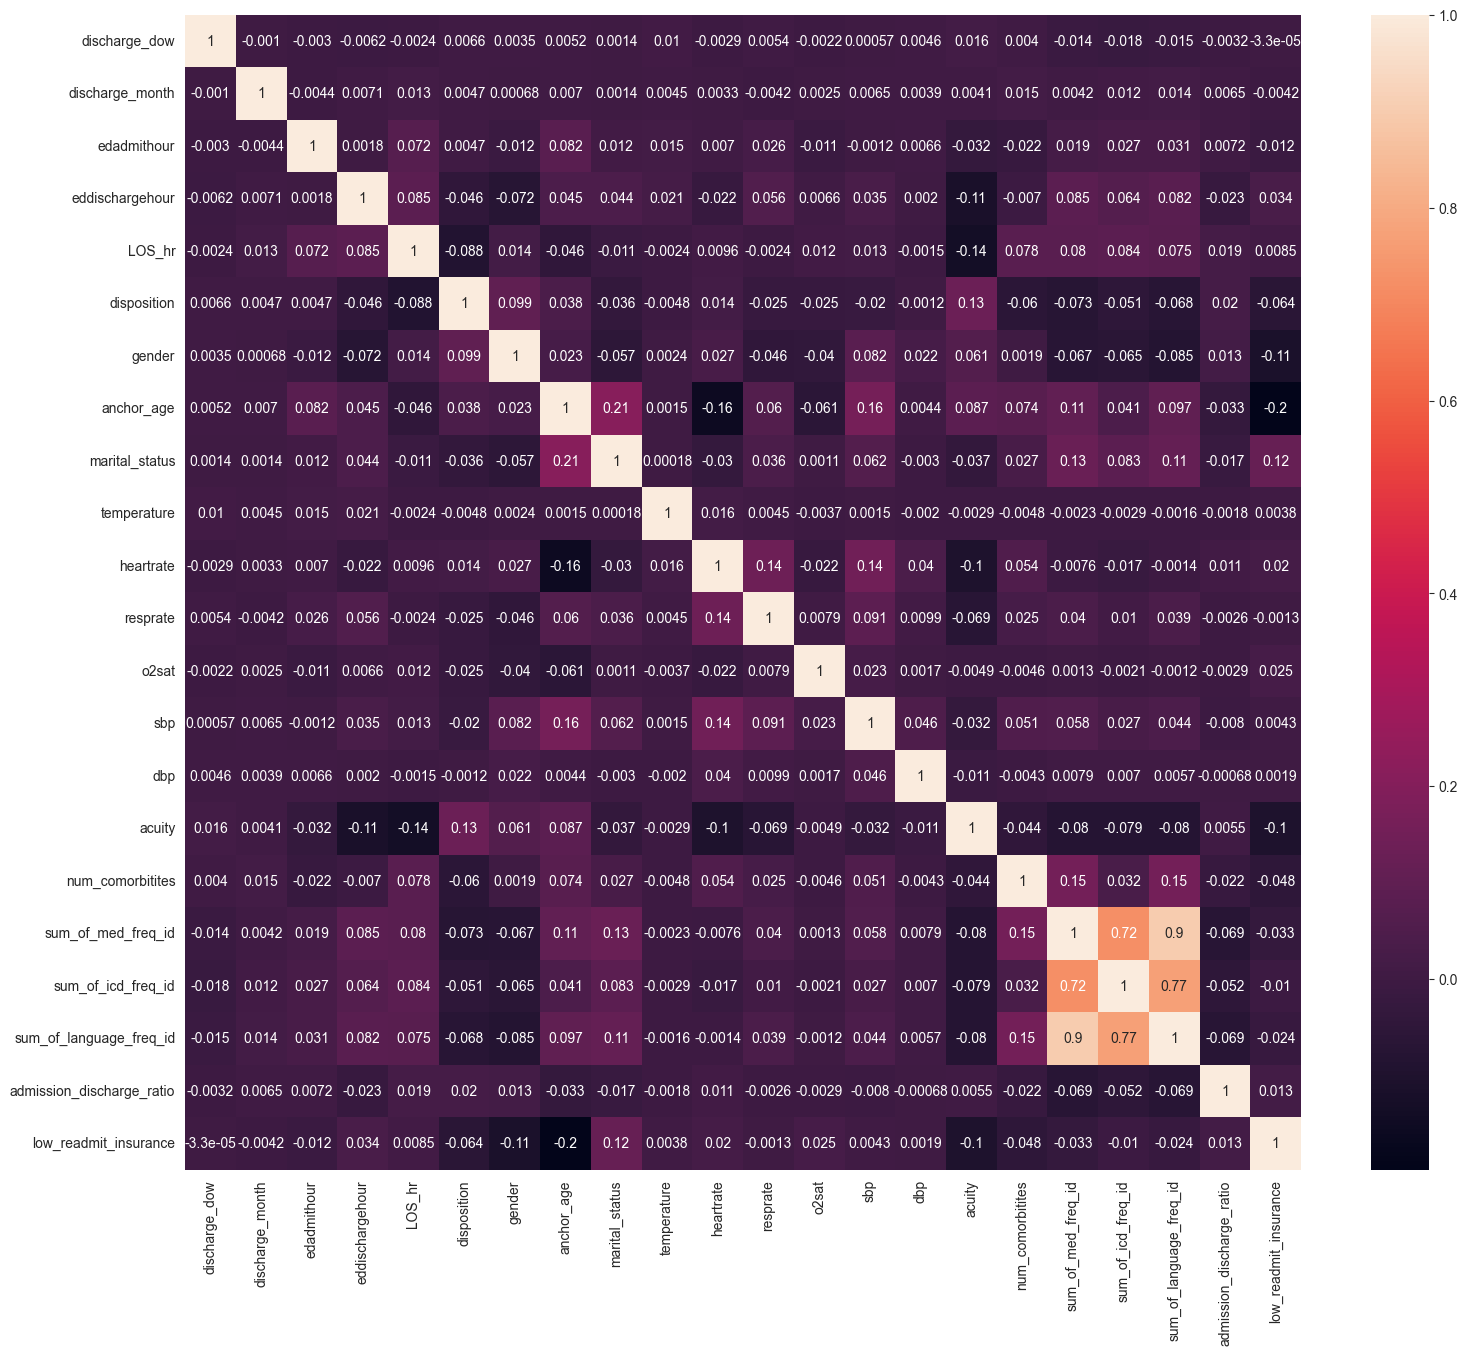

In [51]:
# Use a correlation matrix to identify which variables are correlated with one another
train_numeric_corr = train_df_cleaned.select_dtypes(include='number').drop(columns=['subject_id','hadm_id','readmit_stay_id'])
train_numeric_corr = train_numeric_corr.iloc[:,:22].corr()
# Plot heatmap
plt.figure(figsize=(18,15))
sns.heatmap(train_numeric_corr,annot=True)

There are some clearly correlated variables that I could consider combining or removing:

Total admissions and total discharges show a strong correlation. I could create a new feature representing the ratio of admissions to discharges to capture this relationship more effectively.

Other variables, such as language, and med freq ids, are also highly correlated but represent distinct concepts. I will keep them as they are for now since tree-based models are generally robust to multicollinearity. If necessary, I can revisit and drop one of them later. 

### Variables Most Correlated with Readmission within 30 days

In [857]:
mask = train_df_cleaned.drop(columns=['subject_id','hadm_id','readmit_stay_id']).corr()['had_readmission_within_30'].abs() > 0.1
mask[mask].index.tolist()

['disposition',
 'gender',
 'anchor_age',
 'acuity',
 'low_readmit_insurance',
 'insurance_Private',
 'race_group_Black / African American',
 'mental_health_category_Mood Disorders',
 'mental_health_category_Substance-Related Mental Disorders',
 'had_readmission_within_30']

### Handling Outliers

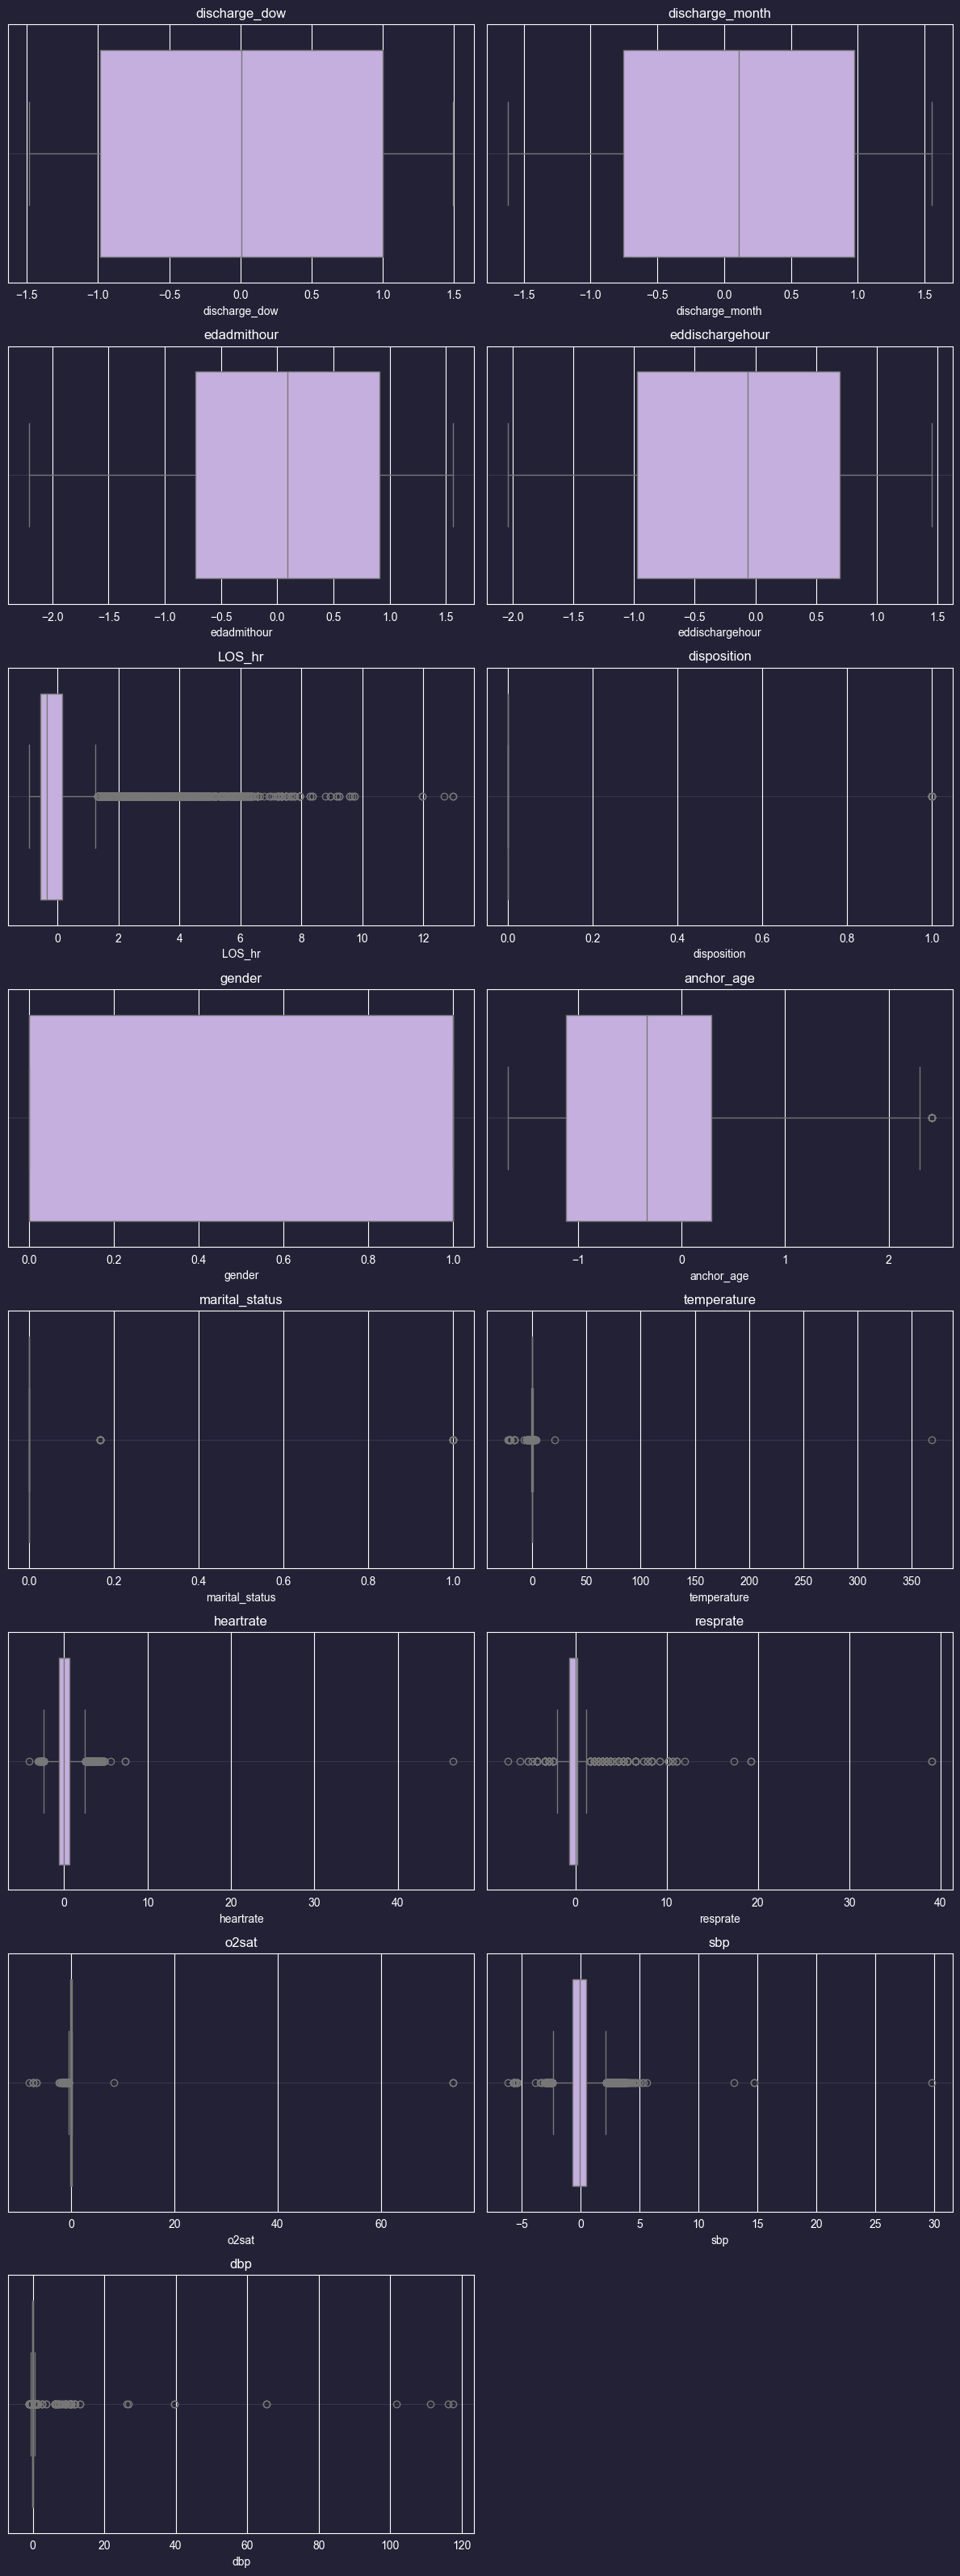

In [860]:
import math
# plot boxplots to identify which columns have outliers
# Select only numeric columns
numeric_columns = train_df_cleaned.select_dtypes(include='number').drop(columns=['subject_id','hadm_id','readmit_stay_id']).iloc[:,:15].columns

# Set up for 2 plots per row
cols = 2
rows = math.ceil(len(numeric_columns) / cols)

fig, axes = plt.subplots(rows, cols, figsize=(12, 4 * rows))
axes = axes.flatten()

for i, column in enumerate(numeric_columns):
    sns.boxplot(data=train_df_cleaned, x=column, ax=axes[i], color='#C4A7E7')
    axes[i].set_title(f'{column}', fontsize=12)
    axes[i].set_xlabel(column)
    # Enable horizontal grid lines (along y-axis) with a light solid line and some transparency
    axes[i].grid(axis='y', linestyle='-', alpha=0.1)
    # Set the figure background color to a dark gray/black shade
    fig.patch.set_facecolor('#232136')
    # Set the axes (plot area) background to the same dark color
    axes[i].set_facecolor('#232136')

# Turn off any unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

There are quite a few columns with outliers that I will have to deal with. While tree based models can handle outliers, I will simply impute them for my base models which are more simple and sensitive to outliers.

In [861]:
class OutlierImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.cols_ = None
        self.skip_columns = [
            'subject_id', 'stay_id', 'hadm_id', 'readmit_stay_id',
            'marital_status', 'gender',
            'sum_of_med_freq_id', 'sum_of_icd_freq_id', 'sum_of_language_freq_id',
            'low_readmit_insurance', 'admission_discharge_ratio'
        ]

    def fit(self, X, y=None):
        # Identify numeric columns to process
        numeric_cols = X.select_dtypes(include='number').columns
        self.cols_ = [col for col in numeric_cols 
                      if col not in self.skip_columns 
                      and col in X.columns][:14]
        return self

    def transform(self, X):
        df = X.copy()
        
        for col in self.cols_:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            LB = Q1 - 1.5 * IQR
            UB = Q3 + 1.5 * IQR

            outliers = (df[col] < LB) | (df[col] > UB)
            num_outliers = outliers.sum()
            median_val = df[col].median()
            df.loc[outliers, col] = median_val

            print(f"{col}: {num_outliers} outlier(s) imputed.")
        
        return df

# Transform Additional Variables

In [862]:
def ConvertLOSHr(x,mean):
    """
    Convert LOS to a binary variable of 
    :return: Binary variables
    """
    if x > mean:
        return 1
    else:
        return 0
    
def SystolicAndDystolicBPConverter(SB, DB):
    """
    Classifies blood pressure based on systolic and diastolic values.

    :param SB: Systolic Blood Pressure (int or float)
    :param DB: Diastolic Blood Pressure (int or float)
    :return: String category (e.g., 'Normal', 'Elevated', 'Stage 1 Hypertension', etc.)
    """
    if SB < 120 and DB < 80:
        return "Normal"
    elif 120 <= SB <= 129 and DB < 80:
        return "Elevated"
    elif (130 <= SB <= 139) or (80 <= DB <= 89):
        return "Stage 1 Hypertension"
    elif (140 <= SB <= 180) or (90 <= DB <= 120):
        return "Stage 2 Hypertension"
    elif SB > 180 or DB > 120:
        return "Hypertensive Crisis"
    else:
        return "Uncategorized"

def O2SatConverter(X):
    """
    :param X: o2sat level
    :return: binary variable
    """
    
    if X < 95:
        return 1
    else:
        return 0

### Update the Preprocessing Pipeline

In [966]:
# Add a transformer to modify total admissions and total discharges to one variable
class GetTotalAdmissionsAndDischarges(BaseEstimator, TransformerMixin):
    """
    Calculates total admissions and discharges per admission day and discharge day, respectively
    """
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self  

    def transform(self, X):
        X_copy = X.copy().reset_index()
        
        # calculate the total admissions and total discharges 
        total_admissions = X_copy.groupby(by='edadmitdate')['stay_id'].count().reset_index().rename(columns={'stay_id':'total_admissions'})
        total_discharges = X_copy.groupby(by='eddischargedate')['stay_id'].count().reset_index().rename(columns={'stay_id':'total_discharges'})
        
        # merge these with original dataframe
        X_copy = X_copy.merge(total_admissions,how='left',on=['edadmitdate'])
        X_copy = X_copy.merge(total_discharges,how='left',on=['eddischargedate'])
        X_copy.drop(['edadmitdate','eddischargedate'],axis=1,inplace=True)
        
        # Create a ratio variable
        X_copy['admission_discharge_ratio'] = np.divide(X_copy['total_admissions'] , X_copy['total_discharges'] + 1e-5)
        X_copy.drop(['total_admissions','total_discharges'],axis=1,inplace=True)
        
        X_copy.set_index('stay_id', inplace=True)
        return X_copy

# Build Preprocessing Pipeline for later preprocessing of new data
X_train_preprocessing_Pipeline = Pipeline(
    [
        ('ConvertVitalSigns',ConvertVitalSignsToFloats()), # Converts vital signs to floats
        ('CelsiusToFahrenheit',CelsiusToFahrenheit()), # Standardizes temperature, converting it to Fahrenheit
        ('GetMedicationFrequencies',GetMedicationFrequencies()),# Converts medications into frequencies
        ('GetDiagnosesFrequencies',GetDiagnosesFrequencies()), # Converts Diagnosis to frequencies
        ('GetLanguageFrequencies',GetLanguageFrequencies()), # Converts languages to frequencies
        ('GetTotalAdmissionsAndDischarges',GetTotalAdmissionsAndDischarges()), # Calcaultes the total number of admissions and discharges for a given day
        ('Scaler', StandardScalar_Custom()), # Scales data
        ('MapGender',GenderMapper()), # Maps gender to 1 or 0, 1: male, 0: female
        ('MaritalStatusMapper',MaritalStatusMapper()), # Maps maritalstats to 1 or 0, 1: ismarried, 0: not married
        ('GetDisposition',GetDisposition()), # Maps disposition to 1 or 0. 1: LWBS, 0: Got treatment
        ('MapInsurance',InsuranceMapper()),# Maps insurance to 1 or 0. 1: low readmission, 0: high readmission
        ('OnehotEncoder',CreateDummies()),
        ('SimpleImputer', NumericImputer(strategy='median')),  # Fill the nulls with the median value for applicable features
    ]
)

# Build X Preprocessing Pipeline to impute outliers
X_train_preprocessing_pipeline_no_out = Pipeline(
    [
        ('ConvertVitalSigns',ConvertVitalSignsToFloats()), # Converts vital signs to floats
        ('CelsiusToFahrenheit',CelsiusToFahrenheit()), # Standardizes temperature, converting it to Fahrenheit
        ('GetMedicationFrequencies',GetMedicationFrequencies()),# Converts medications into frequencies
        ('GetDiagnosesFrequencies',GetDiagnosesFrequencies()), # Converts Diagnosis to frequencies
        ('GetLanguageFrequencies',GetLanguageFrequencies()), # Converts languages to frequencies
        ('GetTotalAdmissionsAndDischarges',GetTotalAdmissionsAndDischarges()), # Calcaultes the total number of admissions and discharges for a given day
        ('Scaler', StandardScalar_Custom()), # Scales data
        ('MapGender',GenderMapper()), # Maps gender to 1 or 0, 1: male, 0: female
        ('MaritalStatusMapper',MaritalStatusMapper()), # Maps maritalstats to 1 or 0, 1: ismarried, 0: not married
        ('GetDisposition',GetDisposition()), # Maps disposition to 1 or 0. 1: LWBS, 0: Got treatment
        ('MapInsurance',InsuranceMapper()),# Maps insurance to 1 or 0. 1: low readmission, 0: high readmission
        ('OnehotEncoder',CreateDummies()),
        ('SimpleImputer', NumericImputer(strategy='median')),  # Fill the nulls with the median value for applicable features
        ('OutlierImputer',OutlierImputer())
    ]
)

train_df_cleaned = X_train_preprocessing_Pipeline.fit_transform(train_df.drop(['had_readmission_within_30'],axis=1))
train_df_cleaned = train_df_cleaned.merge(train_df[['had_readmission_within_30']],left_index=True,right_index=True,how='left')
train_df_cleaned.drop_duplicates(inplace=True)
train_df_cleaned['bp_category'] = train_df_cleaned.apply(lambda row: SystolicAndDystolicBPConverter(row['sbp'], row['dbp']),axis=1)
train_df_cleaned['AboveAvgLOS'] = train_df_cleaned['LOS_hr'].apply(lambda x: ConvertLOSHr(x,train_df_cleaned['LOS_hr'].mean()))
train_df_cleaned['nonNormalo2sat'] = train_df_cleaned['o2sat'].apply(lambda x: O2SatConverter(x))
train_df_cleaned = pd.get_dummies(train_df_cleaned,columns=['bp_category'])


train_df_cleaned_no_out = X_train_preprocessing_pipeline_no_out.fit_transform(train_df.drop(['had_readmission_within_30'],axis=1))
train_df_cleaned_no_out = train_df_cleaned_no_out.merge(train_df[['had_readmission_within_30']],left_index=True,right_index=True,how='left')
train_df_cleaned_no_out.drop_duplicates(inplace=True)

train_df_cleaned_no_out['bp_category'] = train_df_cleaned_no_out.apply(lambda row: SystolicAndDystolicBPConverter(row['sbp'], row['dbp']),axis=1)
train_df_cleaned_no_out['AboveAvgLOS'] = train_df_cleaned_no_out['LOS_hr'].apply(lambda x: ConvertLOSHr(x,train_df_cleaned_no_out['LOS_hr'].mean()))
train_df_cleaned_no_out['nonNormalo2sat'] = train_df_cleaned_no_out['o2sat'].apply(lambda x: O2SatConverter(x))
train_df_cleaned_no_out = pd.get_dummies(train_df_cleaned_no_out,columns=['bp_category'])

discharge_dow: 0 outlier(s) imputed.
discharge_month: 0 outlier(s) imputed.
edadmithour: 0 outlier(s) imputed.
eddischargehour: 0 outlier(s) imputed.
LOS_hr: 12471 outlier(s) imputed.
disposition: 6821 outlier(s) imputed.
anchor_age: 0 outlier(s) imputed.
temperature: 7177 outlier(s) imputed.
heartrate: 1536 outlier(s) imputed.
resprate: 9844 outlier(s) imputed.
o2sat: 2032 outlier(s) imputed.
sbp: 4340 outlier(s) imputed.
dbp: 3594 outlier(s) imputed.
acuity: 295 outlier(s) imputed.


### Preprocess the Test Set

In [969]:
# Use the X Train preprocessing Pipeline to transform the test data
test_df.set_index('stay_id',inplace=True)
test_df_cleaned = X_train_preprocessing_Pipeline.transform(test_df.drop(['had_readmission_within_30'], axis=1))
test_df_cleaned = test_df_cleaned.merge(test_df[['had_readmission_within_30']], left_index=True, right_index=True, how='left')
test_df_cleaned.drop_duplicates(inplace=True)
test_df_cleaned['bp_category'] = test_df_cleaned.apply(lambda row: SystolicAndDystolicBPConverter(row['sbp'], row['dbp']),axis=1)
test_df_cleaned['AboveAvgLOS'] = test_df_cleaned['LOS_hr'].apply(lambda x: ConvertLOSHr(x,test_df_cleaned['LOS_hr'].mean()))
test_df_cleaned['nonNormalo2sat'] = test_df_cleaned['o2sat'].apply(lambda x: O2SatConverter(x))
test_df_cleaned = pd.get_dummies(test_df_cleaned,columns=['bp_category'])

In [970]:
# Get the shapes of the train and test dfs
print('Train Shape:',train_df_cleaned.shape)
print('Test Shape:',test_df_cleaned.shape)

Train Shape: (51028, 56)
Test Shape: (30373, 56)


### Create Train, Validation, Test Splits

In [971]:
# Create the X_train, y_train variables
X_train = train_df_cleaned.drop(['subject_id','hadm_id','readmit_stay_id','had_readmission_within_30'],axis=1)
y_train = train_df_cleaned['had_readmission_within_30']

# Create a validation set
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size=0.20,random_state=42,stratify=y_train) # use stratify to ensure both sets have the same class distribution as the original set

# Create the X_train_removed_outliers, y_train_removed_outliers variables
X_train_no_out = train_df_cleaned_no_out.drop(['subject_id','hadm_id','readmit_stay_id','had_readmission_within_30'],axis=1)
y_train_no_out = train_df_cleaned_no_out['had_readmission_within_30']

# Create a validation set no outliers
X_train_no_out,X_val_no_out,y_train_no_out,y_val_no_out = train_test_split(X_train_no_out,y_train_no_out,test_size=0.20,random_state=42)

# Create the X_test, y_test variables
X_test = test_df_cleaned.drop(['subject_id','hadm_id','readmit_stay_id','had_readmission_within_30'],axis=1)
y_test = test_df_cleaned['had_readmission_within_30']



print('X_train Shape:',X_train.shape)
print('y_train Shape:',y_train.shape)
print('X_train_no_out Shape:',X_train_no_out.shape)
print('y_train_no_out Shape:',y_train_no_out.shape)
print('X_val Shape:',X_val.shape)
print('y_val Shape:',y_val.shape)
print('X_test Shape:',X_test.shape)
print('y_test Shape:',y_test.shape)

X_train Shape: (40822, 52)
y_train Shape: (40822,)
X_train_no_out Shape: (40822, 51)
y_train_no_out Shape: (40822,)
X_val Shape: (10206, 52)
y_val Shape: (10206,)
X_test Shape: (30373, 52)
y_test Shape: (30373,)


### Model Building

To start, I will use simple base models and then experiment with more complex tree-based models, which tend to be more robust and can fit non-linear datasets well but are less interpretable.

In [435]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

#### Naive Bayes Model

In [39]:
X_train.columns

Index(['discharge_dow', 'discharge_month', 'edadmithour', 'eddischargehour',
       'LOS_hr', 'disposition', 'gender', 'anchor_age', 'marital_status',
       'temperature', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'acuity',
       'num_comorbitites', 'sum_of_med_freq_id', 'sum_of_icd_freq_id',
       'sum_of_language_freq_id', 'admission_discharge_ratio',
       'low_readmit_insurance', 'arrival_transport_HELICOPTER',
       'arrival_transport_OTHER', 'arrival_transport_UNKNOWN',
       'arrival_transport_WALK IN', 'insurance_Medicare',
       'insurance_No charge', 'insurance_Other', 'insurance_Private',
       'race_group_Asian', 'race_group_Black / African American',
       'race_group_Hispanic / Latino', 'race_group_Multiple Race / Ethnicity',
       'race_group_Native Hawaiian / Pacific Islander', 'race_group_Other',
       'race_group_Unknown / Declined / Unable to Obtain', 'race_group_White',
       'mental_health_category_Behavioral Syndromes',
       'mental_health_cate

In [868]:
# Use the most correlated cols with readmission
nb_cols = ['disposition',
 'gender',
 'anchor_age',
 'marital_status',
 'acuity',
 'sum_of_icd_freq_id',
 'low_readmit_insurance',
 'insurance_Other',
 'insurance_Private',
 'race_group_Asian',
 'race_group_Black / African American',
 'race_group_White',
 'mental_health_category_Mood Disorders',
 'mental_health_category_Organic Mental Health Disorders',
 'mental_health_category_Substance-Related Mental Disorders',
  'bp_category_Stage 2 Hypertension','nonNormalo2sat','AboveAvgLOS']
X_train_NB = X_train[nb_cols]
X_val_NB = X_val[nb_cols]

naive_bayes = BernoulliNB()
naive_bayes.fit(X_train_NB,y_train)

BernoulliNB()

In [869]:
# Use predictions to see how well the model fits the data
nb_y_pred_train = naive_bayes.predict(X_train_NB)
nb_y_pred_val = naive_bayes.predict(X_val_NB)

In [870]:
# Use the bianry F1 score due the data being imbalanced, and its more important for the model to be able to identify readmissions than not
print("Best Model F1 score on train set: ",f1_score(y_train,nb_y_pred_train,average='binary'))
print("Best Model F1 score on validation set: ",f1_score(y_val,nb_y_pred_val,average='binary'))

Best Model F1 score on train set:  0.4514683679929869
Best Model F1 score on validation set:  0.46304262807978097


In [871]:
# Store and print the classification report
NB_classification_report = classification_report(y_val, nb_y_pred_val,output_dict=True)
print(classification_report(y_val, nb_y_pred_val))

              precision    recall  f1-score   support

         0.0       0.80      0.85      0.82      7406
         1.0       0.51      0.42      0.46      2800

    accuracy                           0.73     10206
   macro avg       0.65      0.64      0.64     10206
weighted avg       0.72      0.73      0.72     10206


- The model's precision indicates that when it predicts readmissions, its accurate about 51% or a bit more than half the time. 
- The recall for the positive class is 41%, indicating the model is only identifying about 41% of actual readmissions.
- This suggests the model struggles more to detect readmissions than to correctly predict non-readmissions.
- Despite these limitations, Naive Bayes — being a simple baseline model — performs reasonably well on this task so far. There is room for improvement, especially in increasing recall for the positive class, which is critical to minimizing missed readmission cases.



In [872]:
def get_classification_metrics(report):
    # Initialize an empty dictionary to store evaluation metrics for each class
    class_evaluations = {}

    # Iterate over each top-level key in the classification report
    for metric in report:
        # Check if the key corresponds to the negative class label '0.0'
        if metric == '0.0':
            # Loop through each metric (precision, recall, f1-score) for class '0.0'
            for key in report['0.0']:
                if key != 'support':  # Skip the 'support' key
                    # Add the metric value to the dictionary with a descriptive key name
                    class_evaluations[f'{key}_neg_class'] = report['0.0'][key]
        
        # Check if the key corresponds to the positive class label '1.0'
        elif metric == '1.0':
            # Loop through each metric for class '1.0'
            for key in report['1.0']:
                if key != 'support':  # Skip the 'support' key
                    # Add the metric value with a suffix indicating it's for the positive class
                    class_evaluations[f'{key}_pos_class'] = report['1.0'][key]

    # Return the dictionary containing metrics for both classes
    return class_evaluations
            
        
nb_eval_values = get_classification_metrics(NB_classification_report)               

Text(0.5, 1.0, 'Naive Bayes Confusion Matrix: Validation Data')

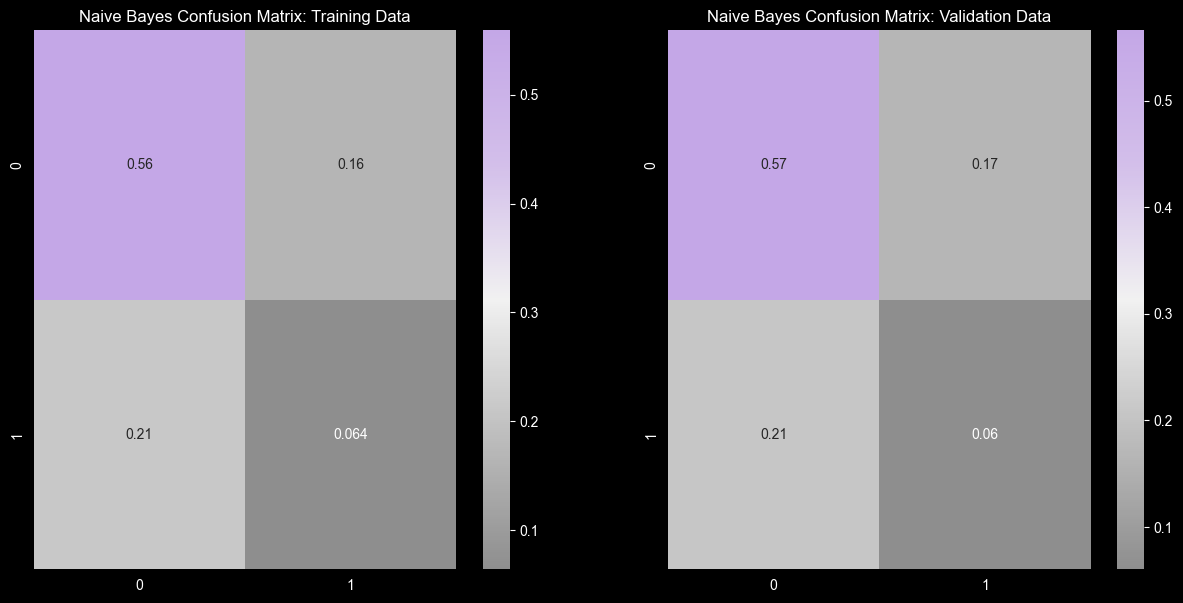

In [1034]:
from sklearn.metrics import confusion_matrix
from matplotlib.colors import LinearSegmentedColormap

train_conf_matrix_rnd_nb = confusion_matrix(y_train_no_out,nb_y_pred_train,normalize='all')
val_conf_matrix_rnd_nb = confusion_matrix(y_val_no_out, nb_y_pred_val,normalize='all')


# Create a confusion Matrix Heatmap of performance on the training and validation set
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2, figsize=(15,7))

# Heatmap: Training Data
custom_cmap = LinearSegmentedColormap.from_list("colormap", ['#8e8e8e','#bebebe','#f1f1f1','#d3bfea','#C4A7E7'])

sns.heatmap(train_conf_matrix_rnd_nb,annot=True,ax=ax1,cmap=custom_cmap)
ax1.set_title("Naive Bayes Confusion Matrix: Training Data")

# Heatmap: Validation Data
sns.heatmap(val_conf_matrix_rnd_nb,annot=True,ax=ax2,cmap=custom_cmap)
ax2.set_title("Naive Bayes Confusion Matrix: Validation Data")

The model performed relatively well at identifying true negatives, correctly classifying patients who were not at risk of readmission within 30 days. However, it exhibited a false positive rate of 16%, meaning some patients were incorrectly flagged as high risk. This could lead to staff misallocating resources and time by targeting individuals who do not actually require intervention. More concerningly, the model struggled to identify true positives, correctly flagging only about 6% of patients who were genuinely at risk. As a result, many at-risk individuals may go unnoticed, potentially leading to inadequate care and missed opportunities for timely intervention.

So, the Naive Bayes model is not a suitable model for this task.

In [1100]:
# create a dataframe with the evaluation metrics from the naive bayes models and then subsequent models
df_class_report = pd.DataFrame()
df_class_report['Naive Bayes'] = nb_eval_values

In [1101]:
df_class_report

,Naive Bayes
precision_neg_class,0.795236
recall_neg_class,0.847421
f1-score_neg_class,0.820499
precision_pos_class,0.511668
recall_pos_class,0.422857
f1-score_pos_class,0.463043


#### Logistic Regression

In [875]:
# GridSearchCV Param search grid
lr_param_grid = {
    'C': np.logspace(-3,3,3),
    'penalty': ['l1'],
    'solver': ['liblinear','saga'],
    'max_iter': [100,500,1000],
    'class_weight':['balanced', {0:1,1:3}]
}

# Use Grid SearchCV to find the best parameters
lr_rs = GridSearchCV(LogisticRegression(), param_grid=lr_param_grid, cv=3, n_jobs=-1,scoring='f1_macro') # use f1 score for model evaluation due to data imbalance

In [876]:
# fit the model to the data
lr_rs.fit(X_train_no_out,y_train_no_out)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The ma

GridSearchCV(cv=3, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e+00, 1.e+03]),
                         'class_weight': ['balanced', {0: 1, 1: 3}],
                         'max_iter': [100, 500, 1000], 'penalty': ['l1'],
                         'solver': ['liblinear', 'saga']},
             scoring='f1_macro')

In [877]:
# Get the best hyperparameters from GridSearchCV
lr_rs.best_params_

{'C': 1.0,
 'class_weight': 'balanced',
 'max_iter': 100,
 'penalty': 'l1',
 'solver': 'liblinear'}

In [878]:
# Make predicitions on the train and validation dataset excluding outliers to check for any over or underfitting
lr_y_pred_train = lr_rs.predict(X_train_no_out)
lr_y_pred_val = lr_rs.predict(X_val_no_out)

In [879]:
# Use the bianry F1 score due the data being imbalanced, and its more important for the model to be able to identify readmissions than not
print("Best model F1 score on train set:", f1_score(y_train_no_out, lr_y_pred_train, average='binary'))
print("Best model F1 score on validation set:", f1_score(y_val_no_out, lr_y_pred_val, average='binary'))

Best model F1 score on train set: 0.5222619999304856
Best model F1 score on validation set: 0.5191935929301298


In [1102]:
# Use the trained logistic regression model with randomized search (lr_rs)
# to predict labels on the validation dataset (excluding outliers)
LR_random_search_y_pred_val = lr_rs.predict(X_val_no_out)

# Generate a classification report comparing the true labels to the predicted labels
# The report is returned as a dictionary using output_dict=True for easier programmatic access
logisitc_regression_classification_report = classification_report(
    y_val_no_out, LR_random_search_y_pred_val, output_dict=True
)

# Get the classification metrics (i.e. recall,precision, and f1) using the created function from earlier
df_class_report['Logistic Regression'] = get_classification_metrics(logisitc_regression_classification_report)

# Print the full text version of the classification report 
print(classification_report(y_val_no_out, LR_random_search_y_pred_val))

              precision    recall  f1-score   support

         0.0       0.85      0.65      0.74      7475
         1.0       0.42      0.69      0.52      2731

    accuracy                           0.66     10206
   macro avg       0.63      0.67      0.63     10206
weighted avg       0.73      0.66      0.68     10206


Text(0.5, 1.0, 'Linear Regression Confusion Matrix: Validation Data')

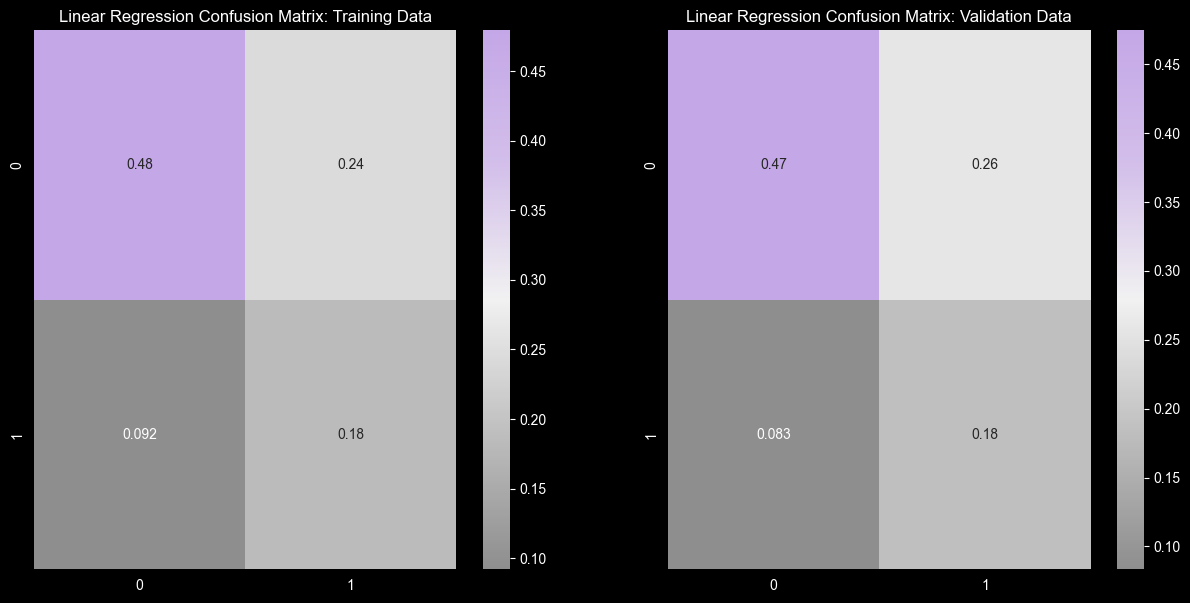

In [1014]:
train_conf_matrix_rnd_lr = confusion_matrix(y_train_no_out, lr_rs.predict(X_train_no_out),normalize='all')
val_conf_matrix_rnd_lr = confusion_matrix(y_val_no_out, lr_rs.predict(X_val_no_out),normalize='all')


# Create a confusion Matrix Heatmap of performance on the training and validation set
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2, figsize=(15,7))

# Heatmap: Training Data
custom_cmap = LinearSegmentedColormap.from_list("colormap", ['#8e8e8e','#bebebe','#f1f1f1','#d3bfea','#C4A7E7'])

sns.heatmap(train_conf_matrix_rnd_lr,annot=True,ax=ax1,cmap=custom_cmap)
ax1.set_title("Linear Regression Confusion Matrix: Training Data")

# Heatmap: Validation Data
sns.heatmap(val_conf_matrix_rnd_lr,annot=True,ax=ax2,cmap=custom_cmap)
ax2.set_title("Linear Regression Confusion Matrix: Validation Data")

The model demonstrated solid performance in identifying true negatives, with a false positive rate of 24%. It performed even better in detecting true positives, correctly flagging approximately 18% of patients genuinely at risk—an improvement of 12 percentage points over the Naive Bayes model. Additionally, the model achieved a relatively low false negative rate of about 9%, reducing the number of at-risk individuals who might otherwise be incorrectly classified as not at risk. However, the results are still not satisfactory for the task at hand.

#### Support Vector Machine

In [882]:
# SVM can take long to train on nonlinear data, so I will use only a sample of the training data and then use the optomized parameters and fit them to the full training data

# Sample only 10%
X_sample, _, y_sample, _ = train_test_split(
    X_train_no_out, y_train_no_out, 
    train_size=0.1, stratify=y_train_no_out, random_state=42
)


In [905]:
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV


svc_param_grid = {
    'C': np.logspace(-3,3,3), # 3 options
    'gamma': np.logspace(-3,3,3), # 3 options
    'class_weight':['balanced',{0: 1, 1: 3}] # 2 options
} # 3 x 3 x 2 = 18 X 3 = 54 combinations

# Use Random SearchCV to find the best parameters
# Randomly select 3 combinations of the 18 options and complete 2 rounds of training on sample data
svc_rand_search = RandomizedSearchCV(SVC(), param_distributions=svc_param_grid,n_iter=10, cv=3, n_jobs=-1,scoring='f1_macro',random_state=42) # use f1 score for model evaluation due to data imbalance
svc_rand_search.fit(X_sample,y_sample)

RandomizedSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
                   param_distributions={'C': array([1.e-03, 1.e+00, 1.e+03]),
                                        'class_weight': ['balanced',
                                                         {0: 1, 1: 3}],
                                        'gamma': array([1.e-03, 1.e+00, 1.e+03])},
                   random_state=42, scoring='f1_macro')

In [915]:
# Use the best parameters from the sample data and train and fit it to the full dataset
svc = SVC(C=1000,class_weight={0:1,1:3},gamma=0.001,probability=True,verbose=1)
svc.fit(X_train_no_out,y_train_no_out)

[LibSVM].........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................*..................................................................................................................................................................................................................................................................................................................................................................................................................*...

SVC(C=1000, class_weight={0: 1, 1: 3}, gamma=0.001, probability=True, verbose=1)

In [916]:
# Get the best hyperparameters
svc_rand_search.best_params_

{'gamma': 0.001, 'class_weight': {0: 1, 1: 3}, 'C': 1000.0}

In [917]:
# Predict y values
svc_y_pred_train = svc.predict(X_train_no_out)
svc_y_pred_val = svc.predict(X_val_no_out)

In [918]:

# Use binary average to get the models score on the positive class
print("Best model F1 score on train set:", f1_score(y_train_no_out, svc_y_pred_train, average='binary'))
print("Best model F1 score on validation set:", f1_score(y_val_no_out, svc_y_pred_val, average='binary'))

Best model F1 score on train set: 0.5687343253636515
Best model F1 score on validation set: 0.5472128945601075


In [919]:
svc_classificatin_report = classification_report(y_val_no_out, svc_y_pred_val,output_dict=True)

In [1104]:
# Get the classification metrics (i.e. recall,precision, and f1) using the created function from earlier
df_class_report['SVC'] = get_classification_metrics(svc_classificatin_report)

In [1035]:
print('------------------------------------------------------------')
print('Classification Report for Support Vector Classifier\n')
print(classification_report(y_val_no_out, svc_y_pred_val))


------------------------------------------------------------
Classification Report for Support Vector Classifier

              precision    recall  f1-score   support

         0.0       0.87      0.64      0.74      7475
         1.0       0.43      0.75      0.55      2731

    accuracy                           0.67     10206
   macro avg       0.65      0.69      0.64     10206
weighted avg       0.76      0.67      0.69     10206


The SVC model demonstrates comparable performance to Logistic Regression on the negative class. However, for the positive class, it achieves a significantly higher recall of 75% compared to both Naive Bayes and Logistic Regression. This improvement in recall is attributed to adjusting the class_weight hyperparameter, which assigns greater importance to the positive class—reflecting the fact that misclassifying a positive case is considered three times more costly than misclassifying a negative one. Despite the increased recall, the model’s precision remains low, indicating that while it successfully identifies about 75% of positive cases, it also generates a substantial number of false positives.


Text(0.5, 1.0, 'SVC Confusion Matrix: Validation Data')

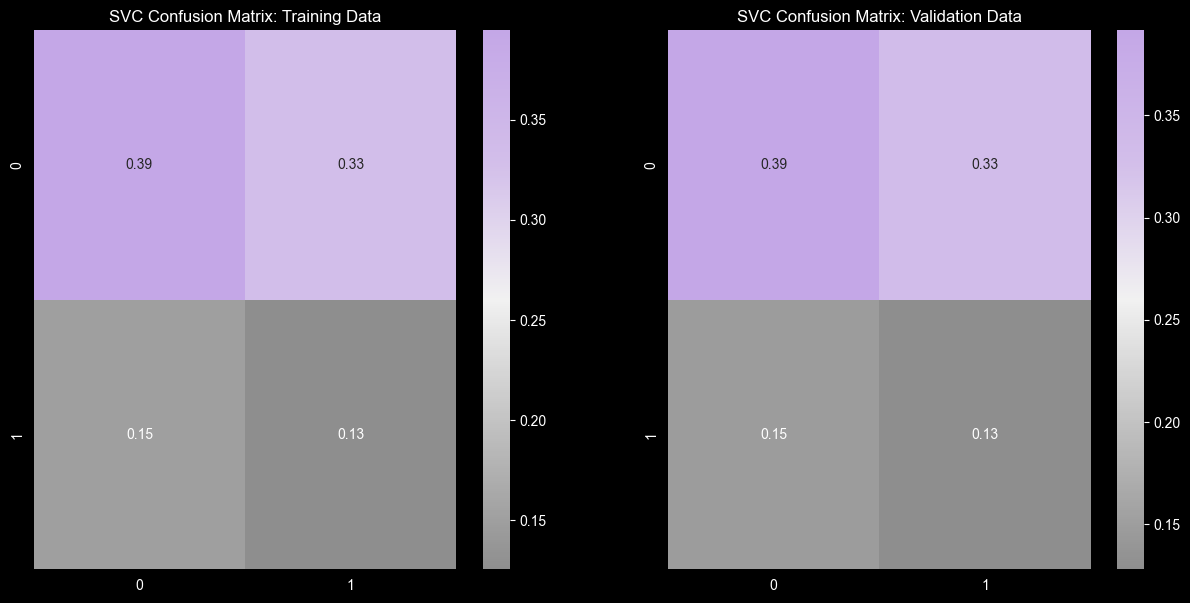

In [1036]:
train_conf_matrix_rnd_svc = confusion_matrix(y_train,svc_y_pred_train,normalize='all')
val_conf_matrix_rnd_svc = confusion_matrix(y_val,svc_y_pred_val,normalize='all')


# Create a confusion Matrix Heatmap of performance on the training and validation set
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2, figsize=(15,7))

# Heatmap: Training Data
custom_cmap = LinearSegmentedColormap.from_list("colormap", ['#8e8e8e','#bebebe','#f1f1f1','#d3bfea','#C4A7E7'])

sns.heatmap(train_conf_matrix_rnd_svc,annot=True,ax=ax1,cmap=custom_cmap)
ax1.set_title("SVC Confusion Matrix: Training Data")

# Heatmap: Validation Data
sns.heatmap(val_conf_matrix_rnd_svc,annot=True,ax=ax2,cmap=custom_cmap)
ax2.set_title("SVC Confusion Matrix: Validation Data")

The confusion matrix indicates that the model predicted fewer true negatives and true positives, while producing more false positives compared to the other two models.

#### Decision Tree

In [1051]:
from sklearn.tree import DecisionTreeClassifier
# Build a Decision Tree Model

dt_clf_params = {
    'splitter':['best'],
    'criterion':['gini','entropy','log_loss'],
    'max_leaf_nodes': [8,10, 16, 20,30], # when a tree should reach its final decision point,smaller values less risk of overfitting
    'max_depth': [1,2,3,4,5], # limits the depth of each decision tree, smaller values less risk of overfitting
    'class_weight':['balanced',{0:1,1:2}], # addresses class imbalance
    'max_features':[6,8,10,12,16,'sqrt', 'log2']
}

# Use Random SearchCV to find the best parameters
dt_rand_search = RandomizedSearchCV(DecisionTreeClassifier(random_state=42), param_distributions=dt_clf_params, cv=20, n_iter=30, n_jobs=-1, random_state=42,scoring='recall') 
dt_rand_search.fit(X_train,y_train)

RandomizedSearchCV(cv=20, estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'class_weight': ['balanced',
                                                         {0: 1, 1: 2}],
                                        'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': [1, 2, 3, 4, 5],
                                        'max_features': [6, 8, 10, 12, 16,
                                                         'sqrt', 'log2'],
                                        'max_leaf_nodes': [8, 10, 16, 20, 30],
                                        'splitter': ['best']},
                   random_state=42, scoring='recall')

In [1052]:
# Get the best hyperparameters
print(dt_rand_search.best_params_)

{'splitter': 'best', 'max_leaf_nodes': 8, 'max_features': 'log2', 'max_depth': 4, 'criterion': 'log_loss', 'class_weight': 'balanced'}


In [1053]:
dt_y_pred_train = dt_rand_search.predict(X_train)
dt_y_pred_val = dt_rand_search.predict(X_val)

In [1054]:
# Use binary average to get the models score on the positive class
print("Best model F1 score on train set:", f1_score(y_train, dt_y_pred_train, average='binary'))
print("Best model F1 score on validation set:", f1_score(y_val, dt_y_pred_val, average='binary'))

Best model F1 score on train set: 0.47946255466883086
Best model F1 score on validation set: 0.47409535781628803


In [1055]:
dt_classificatin_report = classification_report(y_val, dt_y_pred_val,output_dict=True)
print(classification_report(y_val, dt_y_pred_val))

              precision    recall  f1-score   support

         0.0       0.91      0.23      0.37      7406
         1.0       0.32      0.94      0.47      2800

    accuracy                           0.43     10206
   macro avg       0.62      0.59      0.42     10206
weighted avg       0.75      0.43      0.40     10206


The Decision Tree model showed improved performance in identifying positive class cases, largely due to modifying the GridSearchCV scoring metric to 'recall'. This guided the model to prioritize hyperparameters that maximize recall. As a result, the model achieved a high recall of 94% for the positive class but only 23% for the negative class. This means the model classifies most cases as positive, leading to a very low precision and a high number of false positives. In practice, such a model would result in many patients being incorrectly flagged as at risk for readmission within 30 days, potentially leading to unnecessary interventions.

In [1105]:
# Get the classification metrics (i.e. recall,precision, and f1) using the created function from earlier
df_class_report['Decision Tree'] = get_classification_metrics(dt_classificatin_report)

Text(0.5, 1.0, 'Decision Tree Confusion Matrix: Validation Data')

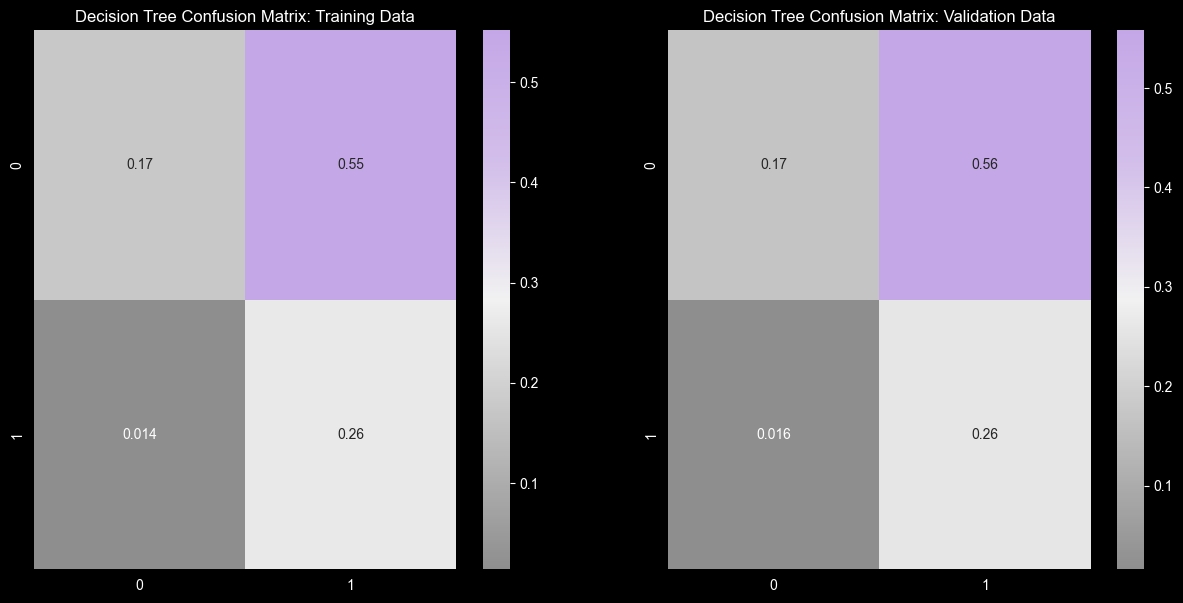

In [1057]:
train_conf_matrix_rnd_dt = confusion_matrix(y_train,dt_y_pred_train,normalize='all')
val_conf_matrix_rnd_dt = confusion_matrix(y_val,dt_y_pred_val,normalize='all')


# Create a confusion Matrix Heatmap of performance on the training and validation set
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2, figsize=(15,7))

# Heatmap: Training Data
custom_cmap = LinearSegmentedColormap.from_list("colormap", ['#8e8e8e','#bebebe','#f1f1f1','#d3bfea','#C4A7E7'])

sns.heatmap(train_conf_matrix_rnd_dt,annot=True,ax=ax1,cmap=custom_cmap)
ax1.set_title("Decision Tree Confusion Matrix: Training Data")

# Heatmap: Validation Data
sns.heatmap(val_conf_matrix_rnd_dt,annot=True,ax=ax2,cmap=custom_cmap)
ax2.set_title("Decision Tree Confusion Matrix: Validation Data")

### Voting Classifier
The Voting Classifier aggregates the predictions of multiple individual classifiers. The class that receives the majority of votes becomes the ensemble's final prediction. This approach is particularly useful when working with several weak learners or models (which is the case here), as combining them can produce a stronger and more robust overall model. It also allows for the use of interpretable models, which is especially important in clinical settings where understanding how a prediction is made can be as critical as the prediction itself—before moving on to more complex, less interpretable models like decision trees or ensemble methods.

In [924]:
from sklearn.ensemble import VotingClassifier
from sklearn.compose import ColumnTransformer

nb_cols = ['disposition','gender','anchor_age','marital_status','acuity','sum_of_icd_freq_id','low_readmit_insurance','insurance_Other','insurance_Private','race_group_Asian','race_group_Black / African American',
 'race_group_White','mental_health_category_Mood Disorders','mental_health_category_Organic Mental Health Disorders','mental_health_category_Substance-Related Mental Disorders','nonNormalo2sat','AboveAvgLOS']

# SVM can take long to train on nonlinear data, so I will use only a sample of the training data and then use the optomized parameters and fit them to the full training data

# Sample only 10%
X_sample, _, y_sample, _ = train_test_split(
    X_train_no_out, y_train_no_out, 
    train_size=0.1, stratify=y_train_no_out, random_state=42
)

# Pipeline
# I need the naive bayes model to only make predictions based off of the binary columns while the others use all the features
bayes_pipe = Pipeline([
    ('selector', ColumnTransformer([('binary', 'passthrough', nb_cols)], remainder='drop')),
    ('clf', BernoulliNB())
])

voting_clf = VotingClassifier(
    estimators=[
        ('bayes',bayes_pipe),
        ('lr',LogisticRegression(C= 1.0,class_weight='balanced',max_iter= 100,penalty='l1',solver='liblinear',random_state=42)),
        ('dt',DecisionTreeClassifier(splitter='best', max_leaf_nodes=30, max_features=10, max_depth= 4, criterion= 'entropy', class_weight= {0: 1, 1: 3},random_state=42)),
        ('svc',SVC(gamma= 0.001, class_weight={0: 1, 1: 3}, C= 1000.0,probability=True))
    ], 
    voting = 'soft'
)
voting_clf_param_grid = {
    'weights': [[1, 2, 3],[1,3,2],None],
    'lr__C': np.logspace(-2,2,4),
    'lr__solver': ['liblinear','saga'],
    'lr__penalty': ['l1'],# 2 options
    'lr__class_weight':['balanced'],
    'lr__max_iter': [500,1000],# 3 options
    'dt__splitter':['best'],
    'dt__criterion':['log_loss'],
    'dt__max_leaf_nodes': [8,10, 16, 20,30], # when a tree should reach its final decision point,smaller values less risk of overfitting
    'dt__max_depth': [ 8, 10, 20], # limits the depth of each decision tree, smaller values less risk of overfitting
    'dt__class_weight':['balanced',{0:1,1:3},None], # addresses class imbalance
    'dt__max_features':[8,16,'sqrt', 'log2'],
    'voting':['soft','hard']
}
voting_rnd_search = RandomizedSearchCV(voting_clf,random_state=42,param_distributions=voting_clf_param_grid,n_iter=3, cv=5, n_jobs=-1,scoring='f1_macro',verbose=3)

In [925]:
voting_rnd_search.fit(X_train_no_out,y_train_no_out)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 3/5] END ......voting=soft, weights=[1, 3, 2];, score=nan total time=   0.1s
[CV 1/5] END ......voting=soft, weights=[1, 3, 2];, score=nan total time=   0.0s
[CV 5/5] END ......voting=soft, weights=[1, 2, 3];, score=nan total time=   0.0s
[CV 3/5] END ......voting=soft, weights=[1, 2, 3];, score=nan total time=   0.0s
[CV 4/5] END ......voting=soft, weights=[1, 3, 2];, score=nan total time=   0.1s
[CV 5/5] END ......voting=soft, weights=[1, 3, 2];, score=nan total time=   0.0s
[CV 1/5] END .........voting=hard, weights=None;, score=0.669 total time=52.0min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
10 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "

[CV 1/5] END ......voting=soft, weights=[1, 2, 3];, score=nan total time=   0.0s
[CV 2/5] END .........voting=hard, weights=None;, score=0.660 total time=52.0min
[CV 4/5] END ......voting=soft, weights=[1, 2, 3];, score=nan total time=   0.0s
[CV 5/5] END .........voting=hard, weights=None;, score=0.666 total time=51.5min
[CV 2/5] END ......voting=soft, weights=[1, 3, 2];, score=nan total time=   0.0s
[CV 3/5] END .........voting=hard, weights=None;, score=0.669 total time=51.7min
[CV 2/5] END ......voting=soft, weights=[1, 2, 3];, score=nan total time=   0.0s
[CV 4/5] END .........voting=hard, weights=None;, score=0.649 total time=51.9min


RandomizedSearchCV(cv=5,
                   estimator=VotingClassifier(estimators=[('bayes',
                                                           Pipeline(steps=[('selector',
                                                                            ColumnTransformer(transformers=[('binary',
                                                                                                             'passthrough',
                                                                                                             ['disposition',
                                                                                                              'gender',
                                                                                                              'anchor_age',
                                                                                                              'marital_status',
                                                                                                              'acuity',
                                                                                                              'sum_of_icd_freq_id',
                                                                                                              'low_readmit_insurance',
                                                                                                              'insurance_Other',
                                                                                                              'insurance_Private',
                                                                                                              'race_group_Asian',
                                                                                                              'race_group_Black '
                                                                                                              '/ '
                                                                                                              'African...
                                                           DecisionTreeClassifier(class_weight={0: 1,
                                                                                                1: 3},
                                                                                  criterion='entropy',
                                                                                  max_depth=4,
                                                                                  max_features=10,
                                                                                  max_leaf_nodes=30,
                                                                                  random_state=42)),
                                                          ('svc',
                                                           SVC(C=1000.0,
                                                               class_weight={0: 1,
                                                                             1: 3},
                                                               gamma=0.001,
                                                               probability=True))],
                                              voting='soft'),
                   n_iter=3, n_jobs=-1,
                   param_distributions={'voting': ['soft', 'hard'],
                                        'weights': [[1, 2, 3], [1, 3, 2],
                                                    None]},
                   random_state=42, scoring='f1_macro', verbose=3)

In [927]:
print(voting_rnd_search.best_estimator_)

VotingClassifier(estimators=[('bayes',
                              Pipeline(steps=[('selector',
                                               ColumnTransformer(transformers=[('binary',
                                                                                'passthrough',
                                                                                ['disposition',
                                                                                 'gender',
                                                                                 'anchor_age',
                                                                                 'marital_status',
                                                                                 'acuity',
                                                                                 'sum_of_icd_freq_id',
                                                                                 'low_readmit_insurance',
                                    

In [928]:
voting_clf_y_pred_train = voting_rnd_search.predict(X_train_no_out)
voting_clf_y_pred_val = voting_rnd_search.predict(X_val_no_out)

# Use binary average to get the models score on the positive class
print("Best model F1 score on train set:", f1_score(y_train_no_out, voting_clf_y_pred_train, average='binary'))
print("Best model F1 score on validation set:", f1_score(y_val_no_out, voting_clf_y_pred_val, average='binary'))

Best model F1 score on train set: 0.5355505982559319
Best model F1 score on validation set: 0.5320626716200937


In [929]:
voting_classificatin_report = classification_report(y_val_no_out, voting_clf_y_pred_val,output_dict=True)
print(classification_report(y_val_no_out, voting_clf_y_pred_val))

              precision    recall  f1-score   support

         0.0       0.84      0.76      0.80      7475
         1.0       0.48      0.60      0.53      2731

    accuracy                           0.72     10206
   macro avg       0.66      0.68      0.66     10206
weighted avg       0.74      0.72      0.73     10206


Combining the Naive Bayes, Logistic Regression, Decision Tree, and SVC models using a Voting Classifier resulted in a more robust model than any of the individual models alone. The ensemble achieved balanced precision and recall for the negative class and showed notable improvement on the positive class. It correctly identified approximately 60% of positive cases with a precision of 48%—a 5 percentage point increase over the SVC model, which previously had the best precision-recall trade-off among the individual models but performed poorly on the negative class.

In [1106]:
# Get the classification metrics (i.e. recall,precision, and f1) using the created function from earlier
df_class_report['Voting Classifier'] = get_classification_metrics(voting_classificatin_report)

Text(0.5, 1.0, 'Voting Classifier Confusion Matrix: Validation Data')

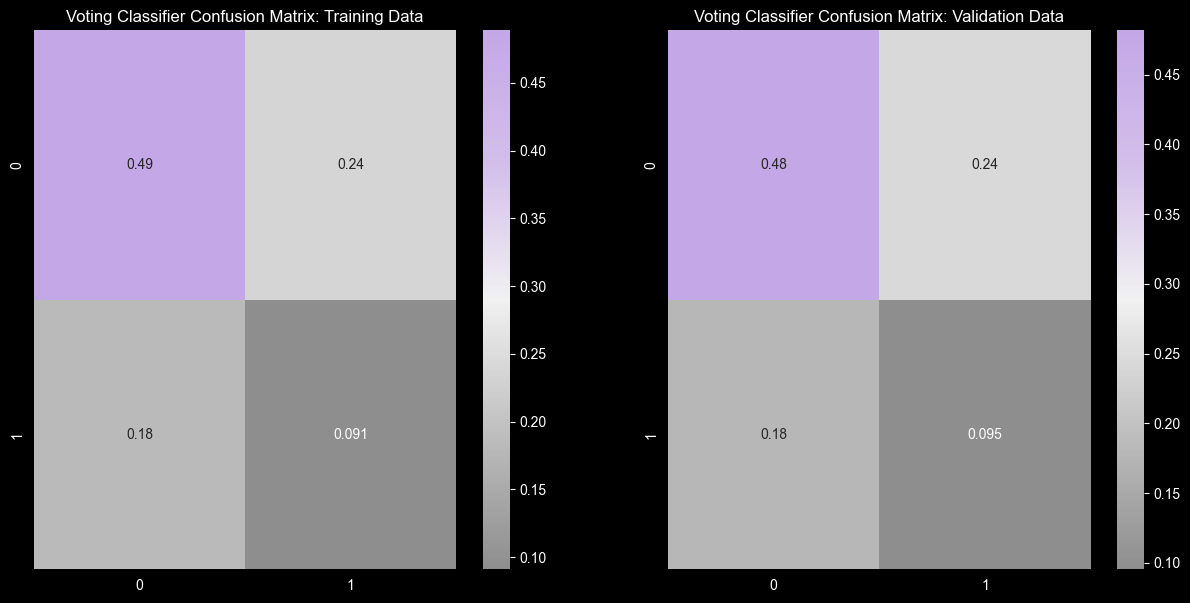

In [1058]:
train_conf_matrix_rnd_vt = confusion_matrix(y_train,voting_clf_y_pred_train,normalize='all')
val_conf_matrix_rnd_vt = confusion_matrix(y_val,voting_clf_y_pred_val,normalize='all')


# Create a confusion Matrix Heatmap of performance on the training and validation set
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2, figsize=(15,7))

# Heatmap: Training Data
custom_cmap = LinearSegmentedColormap.from_list("colormap", ['#8e8e8e','#bebebe','#f1f1f1','#d3bfea','#C4A7E7'])

sns.heatmap(train_conf_matrix_rnd_vt,annot=True,ax=ax1,cmap=custom_cmap)
ax1.set_title("Voting Classifier Confusion Matrix: Training Data")

# Heatmap: Validation Data
sns.heatmap(val_conf_matrix_rnd_vt,annot=True,ax=ax2,cmap=custom_cmap)
ax2.set_title("Voting Classifier Confusion Matrix: Validation Data")

### Feature Selection with Random Forest Model

Using the Random Forest Model or any other tree based model can be very effective for quickly seeing what features are important in your model. So, I will use a random forest here to do that.

In [237]:
from sklearn.ensemble import RandomForestClassifier


In [1066]:
from sklearn.model_selection import RepeatedStratifiedKFold
# The Random Forest Classifier is an ensemble model that trains on random samples of the training data provided (bootstrapping). It takes the classification from each of the models trained on a random sample of the data and selects the classification based on the majority of the models.The randomness of samples helps to reduce overfitting compared to if a single decision tree was used. While this model is robust, when the data is imbalanced predictions are degraded.


# Build a Random Forest Model

rnd_clf_params = {
    'n_estimators': [100, 200, 500,1000], # how many decision trees to train
    'max_leaf_nodes': [8,10, 16, 20], # when a tree should reach its final decision point,smaller values less risk of overfitting
    'max_depth': [None, 8, 10, 20], # limits the depth of each decision tree, smaller values less risk of overfitting
    'class_weight':['balanced',{0:1,1:2}], # addresses class imbalance
    'max_features':[8,16,'sqrt', 'log2'],
    'criterion':['gini','entropy']
}

# Use RepeatedStratifiedKFold to ensure that each cv maintains the class distribution as the original data
cv = RepeatedStratifiedKFold(n_splits=3,n_repeats=3)
# Use Random SearchCV to find the best parameters
rnd_rand_search = RandomizedSearchCV(RandomForestClassifier(), param_distributions=rnd_clf_params, cv=cv, n_iter=10, n_jobs=-1, random_state=42,scoring='recall',verbose=1) 
rnd_rand_search.fit(X_train,y_train)


Fitting 9 folds for each of 10 candidates, totalling 90 fits


RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=3, random_state=None),
                   estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'class_weight': ['balanced',
                                                         {0: 1, 1: 2}],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [None, 8, 10, 20],
                                        'max_features': [8, 16, 'sqrt', 'log2'],
                                        'max_leaf_nodes': [8, 10, 16, 20],
                                        'n_estimators': [100, 200, 500, 1000]},
                   random_state=42, scoring='recall', verbose=1)

In [1067]:

rdf_y_pred_train = rnd_rand_search.predict(X_train)
rdf_y_pred_val = rnd_rand_search.predict(X_val)

# Use binary F1 score
print("F1 score: Best model score on train set:", f1_score(y_train, rdf_y_pred_train, average='binary'))
print("F1 score: Best model validation on train set:", f1_score(y_val, rdf_y_pred_val, average='binary'))


F1 score: Best model score on train set: 0.5601216526963875
F1 score: Best model validation on train set: 0.5483966745843231


In [1068]:
print(classification_report(y_val, rdf_y_pred_val))

              precision    recall  f1-score   support

         0.0       0.85      0.72      0.78      7406
         1.0       0.47      0.66      0.55      2800

    accuracy                           0.70     10206
   macro avg       0.66      0.69      0.66     10206
weighted avg       0.74      0.70      0.71     10206


The RandomForest model, immediately has the best precision-recall trade-off compared to the other models overall

In [935]:
# Get the best hyperparameters found by RandomSearchCV
best_params = rnd_rand_search.best_params_

In [936]:
# Get Feature Importances
rnd_clf_optomized = RandomForestClassifier(n_estimators=best_params['n_estimators'], max_leaf_nodes=best_params['max_leaf_nodes'],n_jobs=-1,random_state=42,class_weight=best_params['class_weight'],max_depth=best_params['max_depth'],criterion=best_params['criterion'])
rnd_clf_optomized.fit(X_train,y_train)

RandomForestClassifier(class_weight='balanced', max_depth=8, max_leaf_nodes=20,
                       n_jobs=-1, random_state=42)

In [937]:
# find the feature importances
importances = rnd_clf_optomized.feature_importances_
feat_importances = pd.DataFrame({'features': X_train.columns, 'importance': importances}).sort_values(by='importance',ascending=False)
feat_importances['cumulative_importance'] = feat_importances['importance'].cumsum()

In [735]:
feat_importances

,features,importance,cumulative_importance
19,sum_of_language_freq_id,0.250300,0.250300
7,anchor_age,0.164925,0.415225
46,mental_health_category_Substance-Related Menta...,0.107842,0.523067
6,gender,0.082488,0.605555
18,sum_of_icd_freq_id,0.076298,0.681853
31,race_group_Black / African American,0.059690,0.741543
17,sum_of_med_freq_id,0.052773,0.794316
15,acuity,0.031771,0.826087
5,disposition,0.029143,0.855230
29,insurance_Private,0.021209,0.876439


In [938]:
# Selecting the features with less than 95% of importance means those features make up 95% of importnace
important_features = feat_importances[feat_importances['cumulative_importance'] <= 0.95]['features'].tolist()


In [939]:
# Only retain the features that were most important in the models prediciton
X_train_rand_imp_feat = X_train[important_features].copy()
X_val_rand_imp_feat = X_val[important_features].copy()
X_test_rand_imp_feat = X_test[important_features].copy()
X_train_no_out_rand_imp_feat = X_train_no_out[important_features].copy()
X_val_no_out_rand_imp_feat = X_val_no_out[important_features].copy()

In [1069]:
# Run the RandomSearchCV again and train the new model with the most important features
rnd_clf_params = {
    'n_estimators': [100, 200, 500,1000], # how many decision trees to train
    'max_leaf_nodes': [8,10, 16, 20], # when a tree should reach its final decision point,smaller values less risk of overfitting
    'max_depth': [None, 8, 10, 20], # limits the depth of each decision tree, smaller values less risk of overfitting
    'class_weight':['balanced',{0:1,1:3}], # addresses class imbalance
    'max_features':[8,16,'sqrt', 'log2'],
    'criterion':['gini','entropy','log_loss']
}

# Use Random SearchCV to find the best parameters
rf_rand_search_imp_feat = RandomizedSearchCV(RandomForestClassifier(), param_distributions=rnd_clf_params, cv=cv, n_iter=10, n_jobs=-1, random_state=42,scoring='recall') 
rf_rand_search_imp_feat.fit(X_train_rand_imp_feat,y_train)


RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=3, random_state=None),
                   estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'class_weight': ['balanced',
                                                         {0: 1, 1: 3}],
                                        'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': [None, 8, 10, 20],
                                        'max_features': [8, 16, 'sqrt', 'log2'],
                                        'max_leaf_nodes': [8, 10, 16, 20],
                                        'n_estimators': [100, 200, 500, 1000]},
                   random_state=42, scoring='recall')

In [1070]:
print(rf_rand_search_imp_feat.best_params_)

{'n_estimators': 100, 'max_leaf_nodes': 20, 'max_features': 16, 'max_depth': 8, 'criterion': 'gini', 'class_weight': {0: 1, 1: 3}}


In [1071]:
# See how well the model fits the data by scoring it on the training data
y_pred_train_imp_feat = rf_rand_search_imp_feat.predict(X_train_rand_imp_feat)
y_pred_val_imp_feat = rf_rand_search_imp_feat.predict(X_val_rand_imp_feat)

In [1072]:
# Get the f1 score
print("F1 score: Best model score on train set:", f1_score(y_train, y_pred_train_imp_feat, average='binary'))
print("F1 score: Best model validation on train set:", f1_score(y_val, y_pred_val_imp_feat, average='binary'))

F1 score: Best model score on train set: 0.544647913913536
F1 score: Best model validation on train set: 0.5376289957211176


In [1107]:
# New RandomForest Model with the best hyperparameters and most important features
optomized_rdf_classification_report = classification_report(y_val, y_pred_val_imp_feat,output_dict=True)

# Get the classification metrics (i.e. recall,precision, and f1) using the created function from earlier
df_class_report['Random Forest Classifier'] = get_classification_metrics(optomized_rdf_classification_report)

print(classification_report(y_val, y_pred_val_imp_feat))

              precision    recall  f1-score   support

         0.0       0.87      0.59      0.71      7406
         1.0       0.42      0.76      0.54      2800

    accuracy                           0.64     10206
   macro avg       0.64      0.68      0.62     10206
weighted avg       0.74      0.64      0.66     10206


After applying RandomizedSearchCV and analyzing the feature importances, the model's performance showed little to no improvement. This suggests that the identified important features had minimal impact on enhancing predictive accuracy. However, using recall as the scoring metric during hyperparameter tuning did lead to a model better optimized for identifying positive cases, favoring higher recall at the expense of precision.

Text(0.5, 1.0, 'Random Forest Classifier Confusion Matrix: Validation Data')

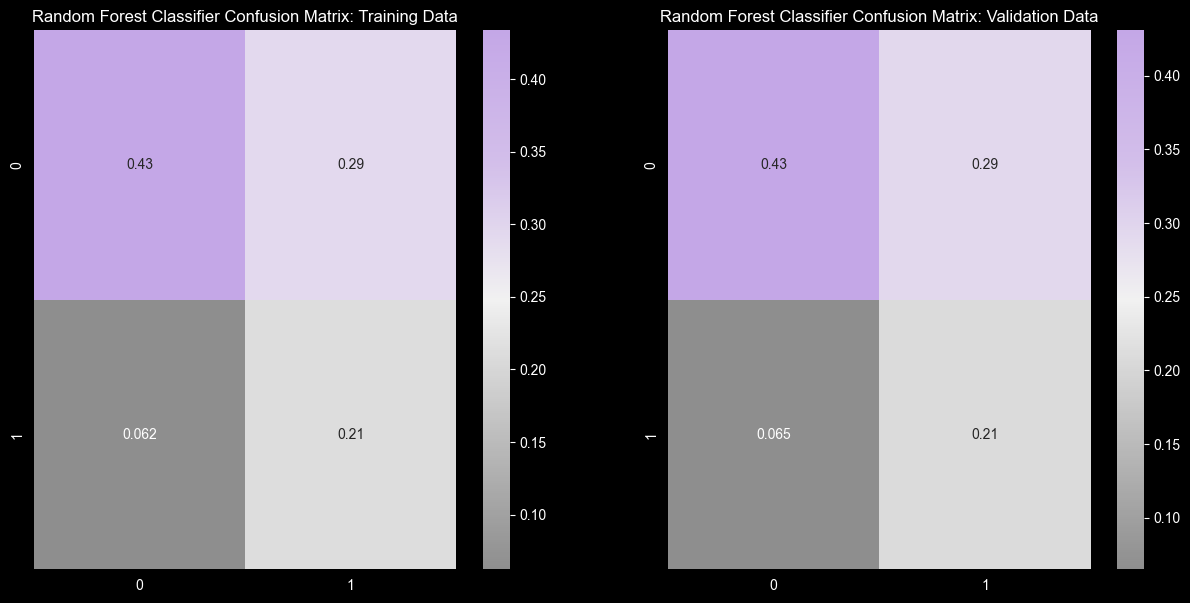

In [1074]:
train_conf_matrix_rnd_rdf = confusion_matrix(y_train,y_pred_train_imp_feat,normalize='all')
val_conf_matrix_rnd_rdf = confusion_matrix(y_val,y_pred_val_imp_feat,normalize='all')


# Create a confusion Matrix Heatmap of performance on the training and validation set
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2, figsize=(15,7))

# Heatmap: Training Data
custom_cmap = LinearSegmentedColormap.from_list("colormap", ['#8e8e8e','#bebebe','#f1f1f1','#d3bfea','#C4A7E7'])

sns.heatmap(train_conf_matrix_rnd_rdf,annot=True,ax=ax1,cmap=custom_cmap)
ax1.set_title("Random Forest Classifier Confusion Matrix: Training Data")

# Heatmap: Validation Data
sns.heatmap(val_conf_matrix_rnd_rdf,annot=True,ax=ax2,cmap=custom_cmap)
ax2.set_title("Random Forest Classifier Confusion Matrix: Validation Data")

The Random Forest Model here makes more False Positive errors compared to the previous voting classifier model but it does have a better True Positive rate compared to the voting classifier

# More Advanced Models

#### Gradient Boositng Classifier

In [1076]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.utils.class_weight import compute_sample_weight # since GradientBoostingClassifier does not inherently have a class_weight parameter, I'm using one from the sklearn library
sample_weights = compute_sample_weight(class_weight='balanced',y=y_train)

param_grid = {
    'n_estimators': [100, 200, 500,1000], # how many decision trees to train
    'max_leaf_nodes': [8,10,16,20], # when a tree should reach its final decision point,smaller values less risk of overfitting
    'max_depth': [None, 8, 10, 20], # limits the depth of each decision tree, smaller values less risk of overfitting
    'learning_rate': list(np.logspace(-3,3,3)),
    'subsample':[0.25,0.10,0.15],
    'max_features':[4,8,10,12],
    'criterion':['friedman_mse', 'squared_error'],
    'n_iter_no_change':[5]
}
# Use RepeatedStratifiedKFold to ensure that each cv maintains the class distribution as the original data
cv = RepeatedStratifiedKFold(n_splits=5,n_repeats=5,random_state=42)

gbrt_rnd_search = RandomizedSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_grid,
    scoring='recall',
    n_iter=30,
    cv=cv,
    n_jobs=-1,
    random_state=42 
)
gbrt_rnd_search.fit(X_train,y_train,sample_weight=sample_weights)

RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=5, n_splits=5, random_state=42),
                   estimator=GradientBoostingClassifier(random_state=42),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'criterion': ['friedman_mse',
                                                      'squared_error'],
                                        'learning_rate': [0.001, 1.0, 1000.0],
                                        'max_depth': [None, 8, 10, 20],
                                        'max_features': [4, 8, 10, 12],
                                        'max_leaf_nodes': [8, 10, 16, 20],
                                        'n_estimators': [100, 200, 500, 1000],
                                        'n_iter_no_change': [5],
                                        'subsample': [0.25, 0.1, 0.15]},
                   random_state=42, scoring='recall')

In [1077]:
# Get the best hyperparameters found by RandomSearchCV
gbrt_rnd_search.best_params_

{'subsample': 0.25,
 'n_iter_no_change': 5,
 'n_estimators': 1000,
 'max_leaf_nodes': 20,
 'max_features': 12,
 'max_depth': None,
 'learning_rate': 0.001,
 'criterion': 'friedman_mse'}

In [1078]:
# See how well the model fits the data by scoring it on the training data
gbd_y_pred_train = gbrt_rnd_search.predict(X_train)
gbd_y_pred_val = gbrt_rnd_search.predict(X_val)


In [1079]:
# Use weighted average due to the data being imbalanced
print("F1 score: Best model score on train set:", f1_score(y_train, gbd_y_pred_train, average='binary'))
print("F1 score: Best model validation on train set:", f1_score(y_val, gbd_y_pred_val, average='binary'))

F1 score: Best model score on train set: 0.5715218574278977
F1 score: Best model validation on train set: 0.5595116988809766


In [1108]:
gbrt_classification_report = classification_report(y_val, gbd_y_pred_val,output_dict=True)
df_class_report['Gradient Boosting Classifier'] = get_classification_metrics(gbrt_classification_report)
print(classification_report(y_val, gbd_y_pred_val))

              precision    recall  f1-score   support

         0.0       0.86      0.71      0.78      7406
         1.0       0.47      0.69      0.56      2800

    accuracy                           0.70     10206
   macro avg       0.66      0.70      0.67     10206
weighted avg       0.75      0.70      0.72     10206


The Gradient Boosting model performs similar to the Random Forest Classifer, Voting Classifier, SVC models but has slightly a better balance between predictions made on the negative and positive class

Text(0.5, 1.0, 'Gradient Boosting Classifier Confusion Matrix: Validation Data')

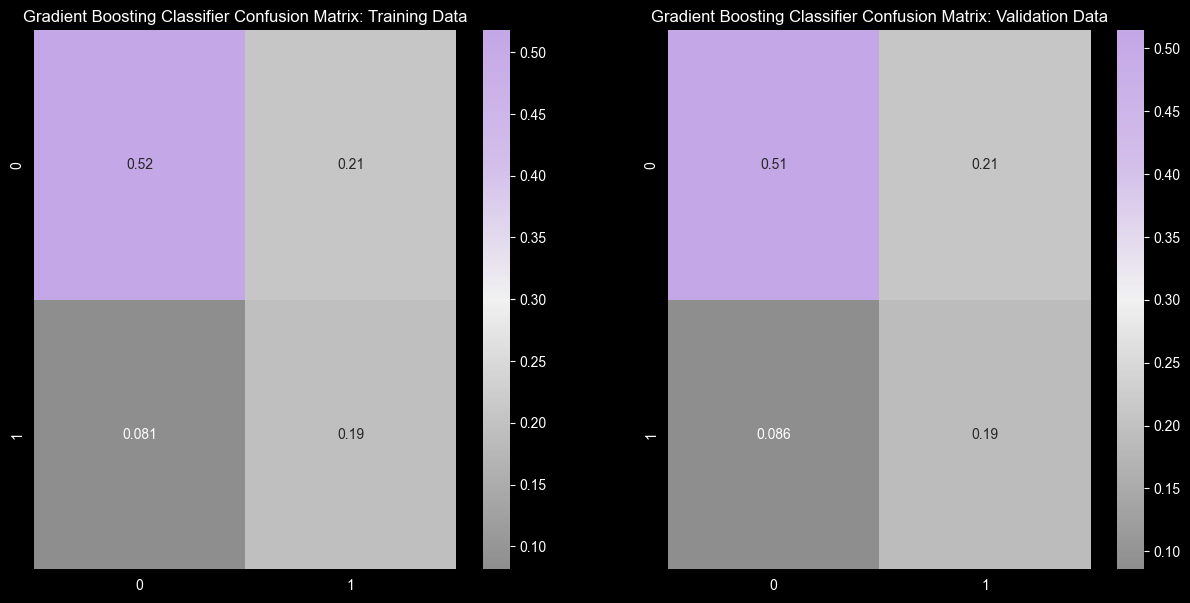

In [1081]:
train_conf_matrix_rnd_gbd = confusion_matrix(y_train,gbd_y_pred_train,normalize='all')
val_conf_matrix_rnd_gbd = confusion_matrix(y_val,gbd_y_pred_val,normalize='all')


# Create a confusion Matrix Heatmap of performance on the training and validation set
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2, figsize=(15,7))

# Heatmap: Training Data
custom_cmap = LinearSegmentedColormap.from_list("colormap", ['#8e8e8e','#bebebe','#f1f1f1','#d3bfea','#C4A7E7'])

sns.heatmap(train_conf_matrix_rnd_gbd,annot=True,ax=ax1,cmap=custom_cmap)
ax1.set_title("Gradient Boosting Classifier Confusion Matrix: Training Data")

# Heatmap: Validation Data
sns.heatmap(val_conf_matrix_rnd_gbd,annot=True,ax=ax2,cmap=custom_cmap)
ax2.set_title("Gradient Boosting Classifier Confusion Matrix: Validation Data")

#### Histogram-Based Gradient Boosting Classifier

In [1084]:
from sklearn.ensemble import HistGradientBoostingClassifier

hgb_param_grid = {
    'max_iter': [100, 200, 500,1000], # how many decision trees to train
    'max_leaf_nodes': [8,10,16,20,31], # when a tree should reach its final decision point,smaller values less risk of overfitting
    'max_depth': [None, 8, 10, 20], # limits the depth of each decision tree, smaller values less risk of overfitting
    'learning_rate': list(np.logspace(-3,3,3)),
    'max_features':[0.5,1.0],
    'max_bins':[100,150,200],
    'class_weight':['balanced',{0:1,1:2},{0:1,1:3}]
}
# Use RepeatedStratifiedKFold to ensure that each cv maintains the class distribution as the original data
cv = RepeatedStratifiedKFold(n_splits=3,n_repeats=3,random_state=42)

hgb_rnd_search = RandomizedSearchCV(
    HistGradientBoostingClassifier(random_state=42),
    hgb_param_grid,
    scoring='recall',
    n_iter=10,
    cv=cv,
    n_jobs=-1,
    random_state=42,
    verbose=1
)
hgb_rnd_search.fit(X_train,y_train)


Fitting 9 folds for each of 10 candidates, totalling 90 fits


RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=3, random_state=42),
                   estimator=HistGradientBoostingClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'class_weight': ['balanced',
                                                         {0: 1, 1: 2},
                                                         {0: 1, 1: 3}],
                                        'learning_rate': [0.001, 1.0, 1000.0],
                                        'max_bins': [100, 150, 200],
                                        'max_depth': [None, 8, 10, 20],
                                        'max_features': [0.5, 1.0],
                                        'max_iter': [100, 200, 500, 1000],
                                        'max_leaf_nodes': [8, 10, 16, 20, 31]},
                   random_state=42, scoring='recall', verbose=1)

In [1085]:
hgb_rnd_search.best_params_

{'max_leaf_nodes': 10,
 'max_iter': 500,
 'max_features': 0.5,
 'max_depth': 20,
 'max_bins': 150,
 'learning_rate': 0.001,
 'class_weight': {0: 1, 1: 3}}

In [1086]:
# See how well the model fits the data by scoring it on the training data
y_pred_train_hgb = hgb_rnd_search.predict(X_train)
y_pred_val_hgb = hgb_rnd_search.predict(X_val)

# Use weighted average due to the data being imbalanced
print("F1 score: Best model score on train set:", f1_score(y_train, y_pred_train_hgb, average='binary'))
print("F1 score: Best model validation on train set:", f1_score(y_val, y_pred_val_hgb, average='binary'))

F1 score: Best model score on train set: 0.5300607971177662
F1 score: Best model validation on train set: 0.5256064690026954


In [1109]:
hgb_classification_report = classification_report(y_val, y_pred_val_hgb,output_dict=True)
df_class_report['Histogram Boosted Gradient Classifier'] = get_classification_metrics(hgb_classification_report)
print(classification_report(y_val, y_pred_val_hgb))

              precision    recall  f1-score   support

         0.0       0.89      0.49      0.63      7406
         1.0       0.38      0.84      0.53      2800

    accuracy                           0.59     10206
   macro avg       0.64      0.66      0.58     10206
weighted avg       0.75      0.59      0.60     10206


The Histogram Gradient Boositng model was able to produce the best results when it came to boosting recall resulting in the best precision-recall trade off.

Text(0.5, 1.0, 'Histogram Gradient Boosting Classifier Confusion Matrix: Validation Data')

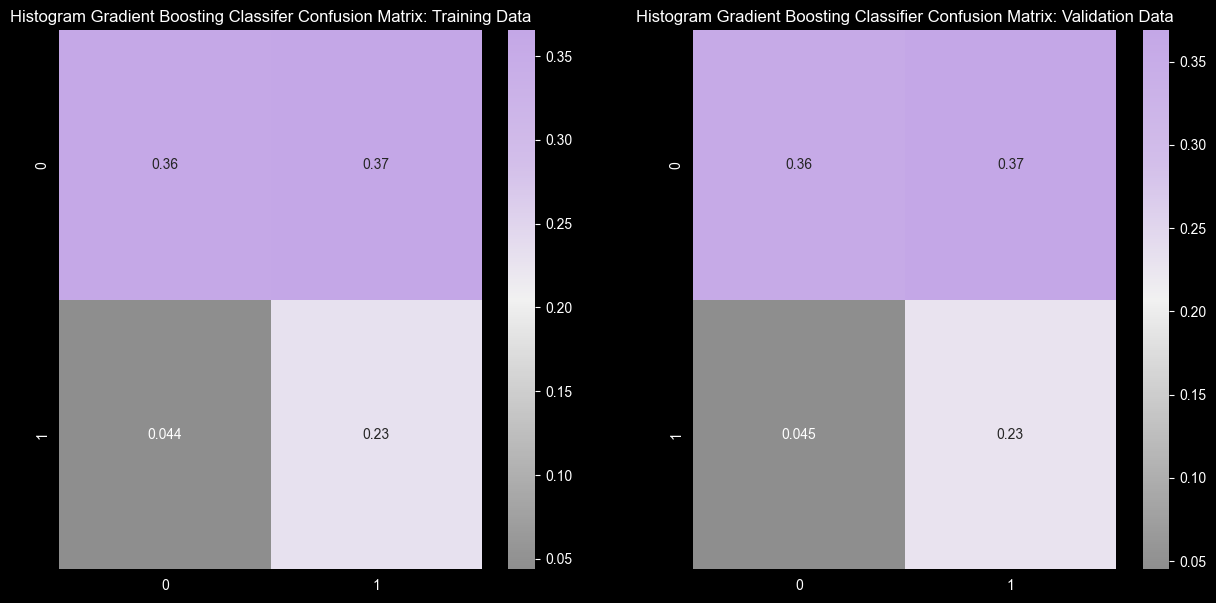

In [1089]:
train_conf_matrix_rnd_gbd = confusion_matrix(y_train,y_pred_train_hgb,normalize='all')
val_conf_matrix_rnd_gbd = confusion_matrix(y_val,y_pred_val_hgb,normalize='all')


# Create a confusion Matrix Heatmap of performance on the training and validation set
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2, figsize=(15,7))

# Heatmap: Training Data
custom_cmap = LinearSegmentedColormap.from_list("colormap", ['#8e8e8e','#bebebe','#f1f1f1','#d3bfea','#C4A7E7'])

sns.heatmap(train_conf_matrix_rnd_gbd,annot=True,ax=ax1,cmap=custom_cmap)
ax1.set_title("Histogram Gradient Boosting Classifer Confusion Matrix: Training Data")

# Heatmap: Validation Data
sns.heatmap(val_conf_matrix_rnd_gbd,annot=True,ax=ax2,cmap=custom_cmap)
ax2.set_title("Histogram Gradient Boosting Classifier Confusion Matrix: Validation Data")

While the model successfully reduces false negatives, it does so at the cost of increasing false positives. As a result, more patients are flagged as at risk for readmission, even when they may not actually be.

# Stacking
Stacking is an ensemble method in which several models are combined much like the voting classifier but instead of using a simple function (such as hard voting) to aggregate the results from each model and thereby predict the target variable, the model is trained to perform this aggregation. What makes this benefical is that a team of helpers to improve predicition accuracy. The first layer contains the base models and then the final layer containts the meta model, which combines all of the predicitions of each model and generates one predicition. 

In [953]:
from sklearn.ensemble import StackingClassifier


base_learners = [
    ('svc',SVC(class_weight={0:1,1:3})),
    ('rf',RandomForestClassifier( max_leaf_nodes= 20, n_estimators=500, max_depth= 20, class_weight= 'balanced')),
]

meta_learner = LogisticRegression()

stack_param = {
    'final_estimator__C': np.logspace(-2,2,4),
    'final_estimator__solver': ['saga'],
    'final_estimator__penalty': ['l1','l2'],# 2 options
    'final_estimator__max_iter': [500,1000],# 2 options
}

stacking_clf = StackingClassifier(estimators=base_learners,final_estimator=meta_learner,cv=5,verbose=1,n_jobs=-1,passthrough=True)

stacking_rnd_search = RandomizedSearchCV(stacking_clf,stack_param,n_iter=10,scoring='f1_macro',n_jobs=-1,cv=2,random_state=42,verbose=2) # try to get a more balanced model using f1_macro

In [954]:
stacking_rnd_search.fit(X_train,y_train)

Fitting 2 folds for each of 10 candidates, totalling 20 fits


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The ma

[CV] END final_estimator__C=100.0, final_estimator__max_iter=1000, final_estimator__penalty=l1, final_estimator__solver=saga; total time=10.3min
[CV] END final_estimator__C=4.6415888336127775, final_estimator__max_iter=500, final_estimator__penalty=l2, final_estimator__solver=saga; total time= 5.7min


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   15.4s remaining:   23.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.6s finished


[CV] END final_estimator__C=0.01, final_estimator__max_iter=500, final_estimator__penalty=l2, final_estimator__solver=saga; total time=10.0min
[CV] END final_estimator__C=4.6415888336127775, final_estimator__max_iter=1000, final_estimator__penalty=l2, final_estimator__solver=saga; total time= 6.1min


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.4min remaining:  3.7min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.5min finished


[CV] END final_estimator__C=0.01, final_estimator__max_iter=500, final_estimator__penalty=l2, final_estimator__solver=saga; total time=10.0min
[CV] END final_estimator__C=4.6415888336127775, final_estimator__max_iter=1000, final_estimator__penalty=l2, final_estimator__solver=saga; total time= 6.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


RandomizedSearchCV(cv=2,
                   estimator=StackingClassifier(cv=5,
                                                estimators=[('svc',
                                                             SVC(class_weight={0: 1,
                                                                               1: 3})),
                                                            ('rf',
                                                             RandomForestClassifier(class_weight='balanced',
                                                                                    max_depth=20,
                                                                                    max_leaf_nodes=20,
                                                                                    n_estimators=500))],
                                                final_estimator=LogisticRegression(),
                                                n_jobs=-1, passthrough=True,
                                                verbose=1),
                   n_jobs=-1,
                   param_distributions={'final_estimator__C': array([1.00000000e-02, 2.15443469e-01, 4.64158883e+00, 1.00000000e+02]),
                                        'final_estimator__max_iter': [500,
                                                                      1000],
                                        'final_estimator__penalty': ['l1',
                                                                     'l2'],
                                        'final_estimator__solver': ['saga']},
                   random_state=42, scoring='f1_macro', verbose=2)

In [515]:
# Get the best hyperparameters found by RandomSearchCV
stacking_rnd_search.best_params_

{'final_estimator__solver': 'liblinear',
 'final_estimator__penalty': 'l1',
 'final_estimator__max_iter': 100,
 'final_estimator__C': 100.0}

In [955]:
# See how well the model fits the data by scoring it on the training data
stacking_y_pred_train = stacking_rnd_search.predict(X_train)
stacking_y_pred_val = stacking_rnd_search.predict(X_val)

[CV] END final_estimator__C=0.01, final_estimator__max_iter=500, final_estimator__penalty=l1, final_estimator__solver=saga; total time=10.0min
[CV] END final_estimator__C=4.6415888336127775, final_estimator__max_iter=500, final_estimator__penalty=l1, final_estimator__solver=saga; total time= 5.9min
[CV] END final_estimator__C=0.01, final_estimator__max_iter=1000, final_estimator__penalty=l1, final_estimator__solver=saga; total time= 3.3min
[CV] END final_estimator__C=0.01, final_estimator__max_iter=500, final_estimator__penalty=l1, final_estimator__solver=saga; total time=10.0min
[CV] END final_estimator__C=100.0, final_estimator__max_iter=500, final_estimator__penalty=l2, final_estimator__solver=saga; total time= 6.0min
[CV] END final_estimator__C=100.0, final_estimator__max_iter=1000, final_estimator__penalty=l2, final_estimator__solver=saga; total time= 3.2min
[CV] END final_estimator__C=100.0, final_estimator__max_iter=1000, final_estimator__penalty=l1, final_estimator__solver=saga

In [956]:
# Use weighted average due to the data being imbalanced
print("F1 score: Best model score on train set:", f1_score(y_train, stacking_y_pred_train, average='binary'))
print("F1 score: Best model validation on train set:", f1_score(y_val, stacking_y_pred_val, average='binary'))

F1 score: Best model score on train set: 0.5720036015041576
F1 score: Best model validation on train set: 0.5056719022687609


In [1110]:
# Generate the classification report for the stacking classifier predictions on validation data
stcking_rnd_learner_classification_report = classification_report(y_val, stacking_y_pred_val, output_dict=True)

# Add the 'macro avg' metrics from the stacking classifier report to the existing DataFrame
df_class_report['Stacking Classifier'] = get_classification_metrics(stcking_rnd_learner_classification_report)

# Print the full classification report in text format for inspection
print(classification_report(y_val, stacking_y_pred_val))

              precision    recall  f1-score   support

         0.0       0.81      0.92      0.86      7406
         1.0       0.65      0.41      0.51      2800

    accuracy                           0.78     10206
   macro avg       0.73      0.66      0.68     10206
weighted avg       0.76      0.78      0.76     10206


This stacking model has much better precision compared to all other models but its at the expense of recall resulting in less cases being classified in favor of the positive class. 

Text(0.5, 1.0, 'Stacking Classifier Confusion Matrix: Validation Data')

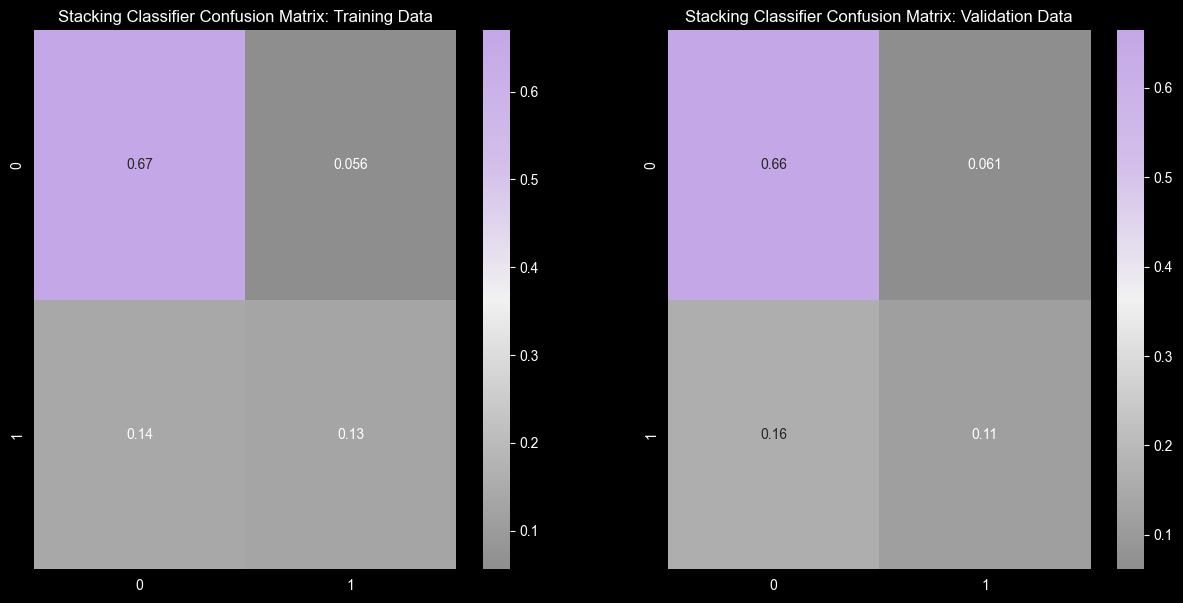

In [1090]:
train_conf_matrix_rnd_stacking = confusion_matrix(y_train,stacking_y_pred_train,normalize='all')
val_conf_matrix_rnd_stacking = confusion_matrix(y_val,stacking_y_pred_val,normalize='all')


# Create a confusion Matrix Heatmap of performance on the training and validation set
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2, figsize=(15,7))

# Heatmap: Training Data
custom_cmap = LinearSegmentedColormap.from_list("colormap", ['#8e8e8e','#bebebe','#f1f1f1','#d3bfea','#C4A7E7'])

sns.heatmap(train_conf_matrix_rnd_stacking,annot=True,ax=ax1,cmap=custom_cmap)
ax1.set_title("Stacking Classifier Confusion Matrix: Training Data")

# Heatmap: Validation Data
sns.heatmap(val_conf_matrix_rnd_stacking,annot=True,ax=ax2,cmap=custom_cmap)
ax2.set_title("Stacking Classifier Confusion Matrix: Validation Data")

# Final Model

Text(0.5, 1.0, 'Model Metric Results on Readmissions')

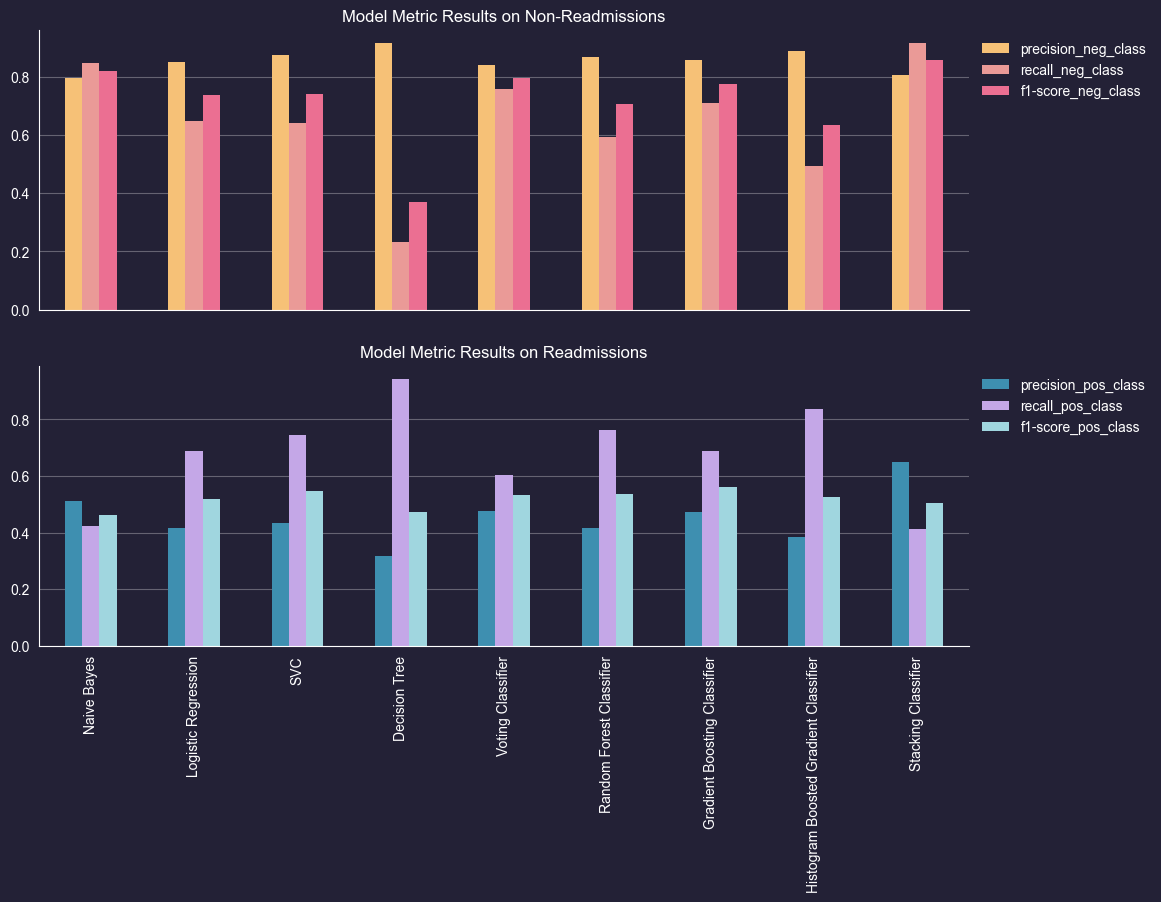

In [1111]:


# Create a figure and a single set of axes with specified size (width=10, height=6 inches)
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(12, 8),sharex=True)

# Define custom colors for the bars (3 colors for the metrics plotted)
neg_colors = ['#F6C177', '#EA9A97', '#EB6F92']
pos_colors = ['#3E8FB0','#C4A7E7','#A0D6DF']

# Plot the transposed classification report data as a bar chart,
# Use the custom colors and remove the white edge/border around bars.
df_class_report.T[['precision_neg_class', 'recall_neg_class', 'f1-score_neg_class']].plot(kind='bar', ax=ax1, color=neg_colors, edgecolor='none')
df_class_report.T[['precision_pos_class', 'recall_pos_class', 'f1-score_pos_class']].plot(kind='bar', ax=ax2, color=pos_colors, edgecolor='none')

# Rotate x-axis tick labels 90 degrees for better readability
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# Remove the top and right spines (the borders around the plot area) for a cleaner look
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Disable vertical grid lines (along x-axis)
ax1.grid(axis='x', visible=False)
ax2.grid(axis='x', visible=False)

# Enable horizontal grid lines (along y-axis) with a light solid line and some transparency
ax1.grid(axis='y', linestyle='-', alpha=0.3)
ax2.grid(axis='y', linestyle='-', alpha=0.3)

# Set the figure background color to a dark gray/black shade
fig.patch.set_facecolor('#232136')

# Set the axes (plot area) background to the same dark color
ax1.set_facecolor('#232136')
ax2.set_facecolor('#232136')

# Change tick marks color to white for contrast on dark background
ax2.tick_params(colors='white')


# Change x-axis and y-axis label colors to white for visibility
ax2.xaxis.label.set_color('white')
ax2.yaxis.label.set_color('white')

# Change the plot title color to white (if a title is added later)
ax2.title.set_color('white')

# Remove Legends Background Colors
legend1 = ax1.legend(bbox_to_anchor=(1, 1))
legend1.get_frame().set_facecolor('none') 
legend1.get_frame().set_edgecolor('none')  # Remove border


legend2 = ax2.legend(bbox_to_anchor=(1, 1))
legend2.get_frame().set_facecolor('none') 
legend2.get_frame().set_edgecolor('none')  # Remove border


# Add titles
ax1.set_title('Model Metric Results on Non-Readmissions')
ax2.set_title('Model Metric Results on Readmissions')

Most models performed reasonably well when predicting the negative class (non-readmissions), likely due to class imbalance—approximately 70% of the dataset consisted of non-readmissions, while only 30% represented readmissions. This imbalance made it easier for models to learn and correctly classify the majority class.

Among the models evaluated, the Stacking Classifier, which combines a Support Vector Classifier (SVC) and Random Forest as base learners with Logistic Regression as the meta-learner, demonstrated the strongest performance on the negative class.

In contrast, predicting the positive class (readmissions) proved more challenging. Performance varied across models, and none achieved an F1 score above 70%. However, the Histogram-based Gradient Boosting (HGB) model stood out as the best performer for the positive class overall. Despite this, it showed signs of overfitting—an issue also seen in other tree-based models—especially when compared to simpler models like Logistic Regression.

For the positive class, the Histogram Gradient Boosting model achieved the following:

F1 Score: ~53%, indicating a moderate balance between precision and recall.

Recall: ~84%, meaning it correctly identified 84% of actual readmissions.

Precision: ~38%, meaning that when the model predicted a readmission, it was correct only 38% of the time.

This means the model strongly favors identifying readmissions (high recall), even at the cost of misclassifying many non-readmission cases as readmissions (low precision). In practice, this results in a higher number of false positives—patients being flagged as high risk when they are not.

While this may lead to staff spending time on patients who ultimately don’t require intervention, it also increases the chances of catching patients who are genuinely at risk. In this context, the model takes a cautious, high-recall approach, prioritizing not missing true readmissions over reducing false alarms—an approach that may be appropriate in healthcare settings where the cost of missing a high-risk patient outweighs the cost of unnecessary follow-up.

# Build Final Model

In [ ]:


def adjust_threshold(x,threshold):
    if x > threshold:
        return 1
    else:
        return 0



In [1198]:
Model = HistGradientBoostingClassifier(max_leaf_nodes= 10,max_iter= 500,max_features=1.0,max_depth= 20,max_bins= 200,learning_rate= 1.0,class_weight= {0: 1, 1: 4})
Model.fit(X_train,y_train)

HistGradientBoostingClassifier(class_weight={0: 1, 1: 4}, learning_rate=1.0,
                               max_bins=200, max_depth=20, max_iter=500,
                               max_leaf_nodes=10)

In [1207]:
y_pred = pd.DataFrame(Model.predict_proba(X_test)[:,1])


thresholds = [0.43,0.46,0.50,0.52,0.53]

for thresh in thresholds:
    # Apply threshold
    predictions = (y_pred >= thresh).astype(int)
    
    print(f'Threshhold = {thresh}')
    print(classification_report(y_test,predictions))
    print('----------------------')


Threshhold = 0.43
              precision    recall  f1-score   support

         0.0       0.88      0.57      0.69     22116
         1.0       0.41      0.79      0.54      8257

    accuracy                           0.63     30373
   macro avg       0.64      0.68      0.61     30373
weighted avg       0.75      0.63      0.65     30373

----------------------
Threshhold = 0.46
              precision    recall  f1-score   support

         0.0       0.87      0.61      0.72     22116
         1.0       0.42      0.76      0.54      8257

    accuracy                           0.65     30373
   macro avg       0.65      0.68      0.63     30373
weighted avg       0.75      0.65      0.67     30373

----------------------
Threshhold = 0.5
              precision    recall  f1-score   support

         0.0       0.86      0.66      0.75     22116
         1.0       0.44      0.71      0.54      8257

    accuracy                           0.67     30373
   macro avg       0.65      

The results indicate that the model struggles to achieve a strong balance between precision and recall. As the classification threshold increases from 0.43 to 0.53, the model becomes more conservative in predicting the positive class. While it consistently identifies a substantial portion of actual positives (high recall), its precision remains relatively low—correctly predicting positive cases only about 40% of the time. This suggests the model tends to over-predict the positive class, leading to a high number of false positives despite threshold adjustments.

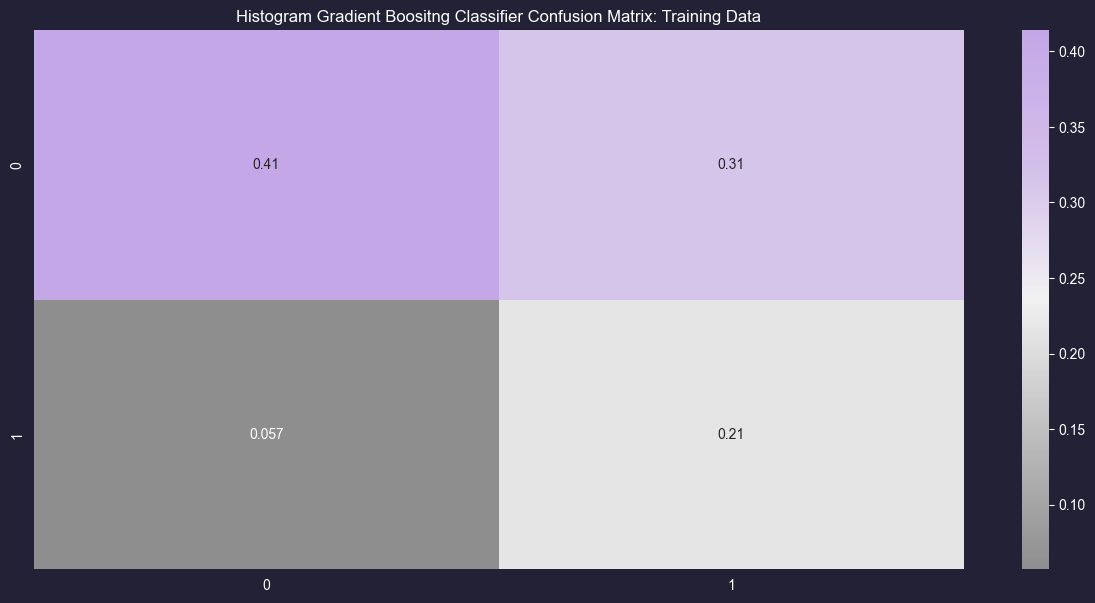

In [1215]:
y_pred= (y_pred >= 0.42)
train_conf_matrix_rnd_final_model = confusion_matrix(y_test,y_pred,normalize='all')

# Create a confusion Matrix Heatmap of performance on the training and validation set
fig, ax1 = plt.subplots(nrows=1,ncols=1, figsize=(15,7))

# Heatmap: Training Data
custom_cmap = LinearSegmentedColormap.from_list("colormap", ['#8e8e8e','#bebebe','#f1f1f1','#d3bfea','#C4A7E7'])

sns.heatmap(train_conf_matrix_rnd_final_model,annot=True,ax=ax1,cmap=custom_cmap)
ax1.set_title("Histogram Gradient Boositng Classifier Confusion Matrix: Training Data")

# Set the figure background color to a dark gray/black shade
fig.patch.set_facecolor('#232136')

# Set the axes (plot area) background to the same dark color
ax1.set_facecolor('#232136')
